# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.77KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

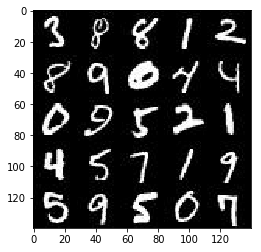

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

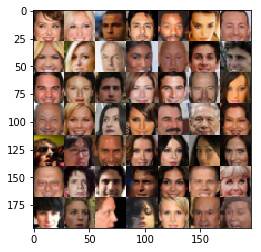

In [3]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, shape=(), name="learning_rate")

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #14x14x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256
        
        x3 = tf.layers.conv2d(relu1, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x512

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #7x7x512
        
        x2 = tf.reshape(x1, (-1, 7, 7, 256))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14*14*128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    #d_loss_real = tf.reduce_mean(
    #    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * (1 - smooth)))

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    #print(data_shape)
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    #print(input_real)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    step = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1

                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if step % 100 == 0:
                    show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)
                    
                # At the end of each epoch, get the losses and print them out
                train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                train_loss_g = g_loss.eval({input_z: batch_z})
            
                print("Epoch {}/{}...".format(epoch_i+1, epochs),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.9424... Generator Loss: 0.1064
Epoch 1/2... Discriminator Loss: 1.6704... Generator Loss: 0.3716
Epoch 1/2... Discriminator Loss: 0.9243... Generator Loss: 0.9867
Epoch 1/2... Discriminator Loss: 0.9207... Generator Loss: 0.9922
Epoch 1/2... Discriminator Loss: 1.2958... Generator Loss: 0.5522
Epoch 1/2... Discriminator Loss: 0.7146... Generator Loss: 1.3416
Epoch 1/2... Discriminator Loss: 0.6009... Generator Loss: 1.6762
Epoch 1/2... Discriminator Loss: 0.6670... Generator Loss: 1.3825
Epoch 1/2... Discriminator Loss: 0.5383... Generator Loss: 1.8615
Epoch 1/2... Discriminator Loss: 0.4945... Generator Loss: 2.0115
Epoch 1/2... Discriminator Loss: 0.5470... Generator Loss: 1.8227
Epoch 1/2... Discriminator Loss: 0.7781... Generator Loss: 1.1804
Epoch 1/2... Discriminator Loss: 0.6892... Generator Loss: 1.4093
Epoch 1/2... Discriminator Loss: 1.0698... Generator Loss: 0.7640
Epoch 1/2... Discriminator Loss: 0.7468... Generator Loss: 1.8288
Epoch 1/2.

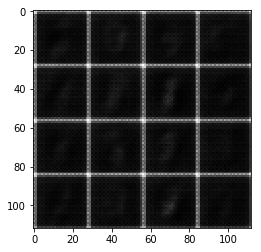

Epoch 1/2... Discriminator Loss: 1.0772... Generator Loss: 0.8606
Epoch 1/2... Discriminator Loss: 0.7987... Generator Loss: 1.9645
Epoch 1/2... Discriminator Loss: 1.3597... Generator Loss: 0.5869
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 2.9254
Epoch 1/2... Discriminator Loss: 2.3006... Generator Loss: 0.2478
Epoch 1/2... Discriminator Loss: 1.6150... Generator Loss: 2.6102
Epoch 1/2... Discriminator Loss: 1.0542... Generator Loss: 1.0480
Epoch 1/2... Discriminator Loss: 1.1417... Generator Loss: 0.8542
Epoch 1/2... Discriminator Loss: 0.9496... Generator Loss: 1.3229
Epoch 1/2... Discriminator Loss: 1.1919... Generator Loss: 0.6998
Epoch 1/2... Discriminator Loss: 0.9616... Generator Loss: 1.3527
Epoch 1/2... Discriminator Loss: 1.0050... Generator Loss: 0.9397
Epoch 1/2... Discriminator Loss: 0.8508... Generator Loss: 1.6806
Epoch 1/2... Discriminator Loss: 1.4897... Generator Loss: 0.4795
Epoch 1/2... Discriminator Loss: 1.1760... Generator Loss: 1.9501
Epoch 1/2.

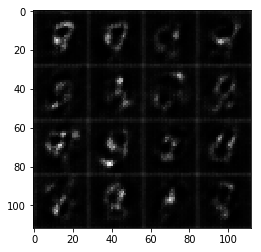

Epoch 1/2... Discriminator Loss: 1.2644... Generator Loss: 0.6001
Epoch 1/2... Discriminator Loss: 1.0429... Generator Loss: 1.1610
Epoch 1/2... Discriminator Loss: 1.0538... Generator Loss: 0.9351
Epoch 1/2... Discriminator Loss: 1.0649... Generator Loss: 0.9967
Epoch 1/2... Discriminator Loss: 1.1138... Generator Loss: 0.9158
Epoch 1/2... Discriminator Loss: 1.0952... Generator Loss: 0.9214
Epoch 1/2... Discriminator Loss: 1.0849... Generator Loss: 1.0318
Epoch 1/2... Discriminator Loss: 1.0910... Generator Loss: 0.7850
Epoch 1/2... Discriminator Loss: 1.0628... Generator Loss: 2.1462
Epoch 1/2... Discriminator Loss: 1.7719... Generator Loss: 0.3470
Epoch 1/2... Discriminator Loss: 1.4616... Generator Loss: 2.7099
Epoch 1/2... Discriminator Loss: 1.3213... Generator Loss: 0.5771
Epoch 1/2... Discriminator Loss: 1.1741... Generator Loss: 0.9894
Epoch 1/2... Discriminator Loss: 1.1833... Generator Loss: 0.8923
Epoch 1/2... Discriminator Loss: 1.1844... Generator Loss: 0.9656
Epoch 1/2.

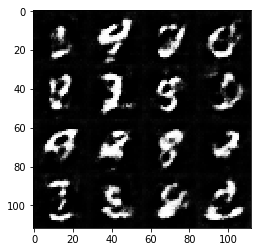

Epoch 1/2... Discriminator Loss: 0.9278... Generator Loss: 1.1758
Epoch 1/2... Discriminator Loss: 1.1250... Generator Loss: 0.7188
Epoch 1/2... Discriminator Loss: 0.9865... Generator Loss: 1.6656
Epoch 1/2... Discriminator Loss: 1.0166... Generator Loss: 0.9768
Epoch 1/2... Discriminator Loss: 0.9598... Generator Loss: 1.0308
Epoch 1/2... Discriminator Loss: 0.9882... Generator Loss: 0.9685
Epoch 1/2... Discriminator Loss: 0.9646... Generator Loss: 1.1894
Epoch 1/2... Discriminator Loss: 0.9162... Generator Loss: 1.0527
Epoch 1/2... Discriminator Loss: 0.9149... Generator Loss: 1.2302
Epoch 1/2... Discriminator Loss: 1.1286... Generator Loss: 0.7088
Epoch 1/2... Discriminator Loss: 1.0236... Generator Loss: 1.5234
Epoch 1/2... Discriminator Loss: 0.9062... Generator Loss: 1.0808
Epoch 1/2... Discriminator Loss: 1.0118... Generator Loss: 0.8800
Epoch 1/2... Discriminator Loss: 0.9406... Generator Loss: 1.3902
Epoch 1/2... Discriminator Loss: 1.0342... Generator Loss: 0.8783
Epoch 1/2.

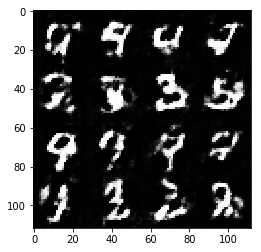

Epoch 1/2... Discriminator Loss: 0.9395... Generator Loss: 1.1890
Epoch 1/2... Discriminator Loss: 0.9994... Generator Loss: 1.0940
Epoch 1/2... Discriminator Loss: 1.0893... Generator Loss: 0.8262
Epoch 1/2... Discriminator Loss: 0.9816... Generator Loss: 1.6938
Epoch 1/2... Discriminator Loss: 1.2888... Generator Loss: 0.6185
Epoch 1/2... Discriminator Loss: 1.0362... Generator Loss: 1.9308
Epoch 1/2... Discriminator Loss: 1.2088... Generator Loss: 0.6411
Epoch 1/2... Discriminator Loss: 0.8913... Generator Loss: 1.7585
Epoch 1/2... Discriminator Loss: 0.9885... Generator Loss: 0.9622
Epoch 1/2... Discriminator Loss: 0.9604... Generator Loss: 1.2310
Epoch 1/2... Discriminator Loss: 1.0332... Generator Loss: 0.9519
Epoch 1/2... Discriminator Loss: 0.9654... Generator Loss: 1.0691
Epoch 1/2... Discriminator Loss: 0.8149... Generator Loss: 1.3227
Epoch 1/2... Discriminator Loss: 0.9446... Generator Loss: 1.1447
Epoch 1/2... Discriminator Loss: 0.8681... Generator Loss: 1.3067
Epoch 1/2.

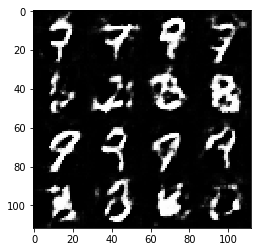

Epoch 1/2... Discriminator Loss: 1.1150... Generator Loss: 0.7337
Epoch 1/2... Discriminator Loss: 0.9421... Generator Loss: 1.3068
Epoch 1/2... Discriminator Loss: 1.0067... Generator Loss: 0.9948
Epoch 1/2... Discriminator Loss: 1.0054... Generator Loss: 1.0347
Epoch 1/2... Discriminator Loss: 1.0580... Generator Loss: 0.8790
Epoch 1/2... Discriminator Loss: 1.0234... Generator Loss: 1.5688
Epoch 1/2... Discriminator Loss: 1.1231... Generator Loss: 0.8116
Epoch 1/2... Discriminator Loss: 0.9046... Generator Loss: 1.6488
Epoch 1/2... Discriminator Loss: 1.1484... Generator Loss: 0.7205
Epoch 1/2... Discriminator Loss: 1.0021... Generator Loss: 1.2688
Epoch 1/2... Discriminator Loss: 1.0629... Generator Loss: 0.8463
Epoch 1/2... Discriminator Loss: 1.0731... Generator Loss: 1.3781
Epoch 1/2... Discriminator Loss: 1.0233... Generator Loss: 0.8964
Epoch 1/2... Discriminator Loss: 0.9990... Generator Loss: 1.3121
Epoch 1/2... Discriminator Loss: 1.0400... Generator Loss: 0.9080
Epoch 1/2.

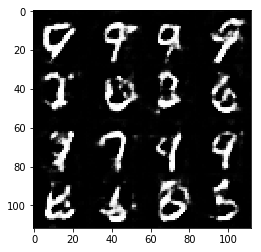

Epoch 1/2... Discriminator Loss: 0.9695... Generator Loss: 0.9750
Epoch 1/2... Discriminator Loss: 0.9988... Generator Loss: 1.1789
Epoch 1/2... Discriminator Loss: 0.8122... Generator Loss: 1.4321
Epoch 1/2... Discriminator Loss: 1.0263... Generator Loss: 0.8531
Epoch 1/2... Discriminator Loss: 0.9152... Generator Loss: 1.4235
Epoch 1/2... Discriminator Loss: 1.2263... Generator Loss: 0.5943
Epoch 1/2... Discriminator Loss: 1.1270... Generator Loss: 1.9641
Epoch 1/2... Discriminator Loss: 1.1125... Generator Loss: 0.7508
Epoch 1/2... Discriminator Loss: 1.0816... Generator Loss: 1.1408
Epoch 1/2... Discriminator Loss: 1.0337... Generator Loss: 0.9583
Epoch 1/2... Discriminator Loss: 0.9520... Generator Loss: 1.5003
Epoch 1/2... Discriminator Loss: 1.2601... Generator Loss: 0.6051
Epoch 1/2... Discriminator Loss: 1.0058... Generator Loss: 1.4723
Epoch 1/2... Discriminator Loss: 1.0506... Generator Loss: 0.8203
Epoch 1/2... Discriminator Loss: 0.9471... Generator Loss: 1.2808
Epoch 1/2.

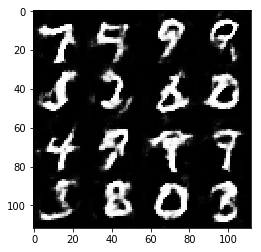

Epoch 1/2... Discriminator Loss: 0.9733... Generator Loss: 1.0247
Epoch 1/2... Discriminator Loss: 1.3459... Generator Loss: 0.5629
Epoch 1/2... Discriminator Loss: 1.3714... Generator Loss: 2.2858
Epoch 1/2... Discriminator Loss: 1.0256... Generator Loss: 0.8520
Epoch 1/2... Discriminator Loss: 0.9327... Generator Loss: 0.9953
Epoch 1/2... Discriminator Loss: 1.0984... Generator Loss: 1.6846
Epoch 1/2... Discriminator Loss: 1.3729... Generator Loss: 0.5257
Epoch 1/2... Discriminator Loss: 1.1174... Generator Loss: 1.7539
Epoch 1/2... Discriminator Loss: 1.0539... Generator Loss: 0.9006
Epoch 1/2... Discriminator Loss: 0.8735... Generator Loss: 1.3782
Epoch 1/2... Discriminator Loss: 0.9871... Generator Loss: 1.1401
Epoch 1/2... Discriminator Loss: 1.1923... Generator Loss: 0.7327
Epoch 1/2... Discriminator Loss: 1.0721... Generator Loss: 1.6038
Epoch 1/2... Discriminator Loss: 1.4248... Generator Loss: 0.4892
Epoch 1/2... Discriminator Loss: 1.1204... Generator Loss: 2.1993
Epoch 1/2.

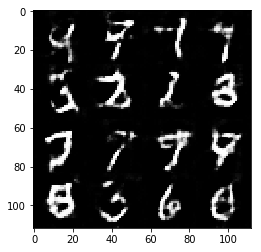

Epoch 1/2... Discriminator Loss: 1.0472... Generator Loss: 1.2488
Epoch 1/2... Discriminator Loss: 1.2035... Generator Loss: 0.7588
Epoch 1/2... Discriminator Loss: 1.0084... Generator Loss: 1.2059
Epoch 1/2... Discriminator Loss: 1.1032... Generator Loss: 0.8357
Epoch 1/2... Discriminator Loss: 0.9696... Generator Loss: 1.4167
Epoch 1/2... Discriminator Loss: 1.3760... Generator Loss: 0.5311
Epoch 1/2... Discriminator Loss: 1.1402... Generator Loss: 1.4458
Epoch 1/2... Discriminator Loss: 0.8553... Generator Loss: 1.2846
Epoch 1/2... Discriminator Loss: 0.9129... Generator Loss: 1.1134
Epoch 1/2... Discriminator Loss: 0.9608... Generator Loss: 0.9491
Epoch 1/2... Discriminator Loss: 1.0929... Generator Loss: 0.9065
Epoch 1/2... Discriminator Loss: 1.0184... Generator Loss: 1.1189
Epoch 1/2... Discriminator Loss: 1.0539... Generator Loss: 0.9161
Epoch 1/2... Discriminator Loss: 0.9861... Generator Loss: 1.3319
Epoch 1/2... Discriminator Loss: 1.0754... Generator Loss: 0.7777
Epoch 1/2.

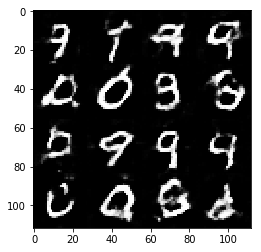

Epoch 1/2... Discriminator Loss: 1.4053... Generator Loss: 0.5164
Epoch 1/2... Discriminator Loss: 1.3646... Generator Loss: 1.9227
Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 0.7363
Epoch 1/2... Discriminator Loss: 1.1285... Generator Loss: 0.9566
Epoch 1/2... Discriminator Loss: 1.1488... Generator Loss: 1.4466
Epoch 1/2... Discriminator Loss: 1.2843... Generator Loss: 0.6044
Epoch 1/2... Discriminator Loss: 1.1168... Generator Loss: 1.5156
Epoch 1/2... Discriminator Loss: 1.1376... Generator Loss: 0.7373
Epoch 1/2... Discriminator Loss: 0.9807... Generator Loss: 1.1359
Epoch 1/2... Discriminator Loss: 0.9824... Generator Loss: 1.3222
Epoch 1/2... Discriminator Loss: 0.9328... Generator Loss: 1.0105
Epoch 1/2... Discriminator Loss: 0.9902... Generator Loss: 1.0750
Epoch 1/2... Discriminator Loss: 0.9627... Generator Loss: 1.2270
Epoch 1/2... Discriminator Loss: 0.9170... Generator Loss: 1.1114
Epoch 1/2... Discriminator Loss: 1.0891... Generator Loss: 0.8100
Epoch 1/2.

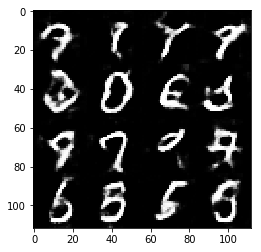

Epoch 1/2... Discriminator Loss: 1.0969... Generator Loss: 0.8811
Epoch 1/2... Discriminator Loss: 1.2392... Generator Loss: 0.7313
Epoch 1/2... Discriminator Loss: 1.1500... Generator Loss: 2.0107
Epoch 1/2... Discriminator Loss: 1.4863... Generator Loss: 0.4793
Epoch 1/2... Discriminator Loss: 1.1588... Generator Loss: 1.4397
Epoch 1/2... Discriminator Loss: 1.0016... Generator Loss: 0.9947
Epoch 1/2... Discriminator Loss: 1.2558... Generator Loss: 0.6552
Epoch 1/2... Discriminator Loss: 1.3024... Generator Loss: 1.8910
Epoch 1/2... Discriminator Loss: 1.1299... Generator Loss: 0.7859
Epoch 1/2... Discriminator Loss: 1.0688... Generator Loss: 0.9256
Epoch 1/2... Discriminator Loss: 1.1026... Generator Loss: 1.8312
Epoch 1/2... Discriminator Loss: 1.5505... Generator Loss: 0.4533
Epoch 1/2... Discriminator Loss: 1.0690... Generator Loss: 1.6965
Epoch 1/2... Discriminator Loss: 1.1854... Generator Loss: 0.7446
Epoch 1/2... Discriminator Loss: 1.1221... Generator Loss: 1.1604
Epoch 1/2.

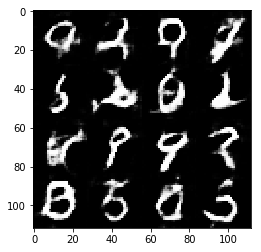

Epoch 1/2... Discriminator Loss: 1.2547... Generator Loss: 1.8727
Epoch 1/2... Discriminator Loss: 1.1450... Generator Loss: 0.7462
Epoch 1/2... Discriminator Loss: 1.0669... Generator Loss: 1.2033
Epoch 1/2... Discriminator Loss: 0.8124... Generator Loss: 1.7155
Epoch 1/2... Discriminator Loss: 1.1579... Generator Loss: 0.6996
Epoch 1/2... Discriminator Loss: 0.9269... Generator Loss: 1.5428
Epoch 1/2... Discriminator Loss: 1.3901... Generator Loss: 0.5165
Epoch 1/2... Discriminator Loss: 1.3182... Generator Loss: 2.1824
Epoch 1/2... Discriminator Loss: 1.3910... Generator Loss: 0.5618
Epoch 1/2... Discriminator Loss: 1.0704... Generator Loss: 1.1481
Epoch 1/2... Discriminator Loss: 1.0313... Generator Loss: 1.0288
Epoch 1/2... Discriminator Loss: 1.1615... Generator Loss: 0.8700
Epoch 1/2... Discriminator Loss: 1.1567... Generator Loss: 0.8734
Epoch 1/2... Discriminator Loss: 0.9979... Generator Loss: 1.0221
Epoch 1/2... Discriminator Loss: 1.0883... Generator Loss: 0.8854
Epoch 1/2.

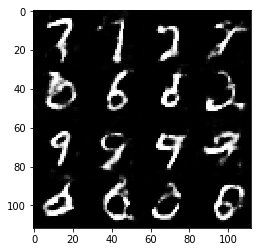

Epoch 1/2... Discriminator Loss: 1.1237... Generator Loss: 1.6590
Epoch 1/2... Discriminator Loss: 1.2254... Generator Loss: 0.6577
Epoch 1/2... Discriminator Loss: 1.0215... Generator Loss: 1.2179
Epoch 1/2... Discriminator Loss: 1.1638... Generator Loss: 0.7586
Epoch 1/2... Discriminator Loss: 1.0913... Generator Loss: 1.1466
Epoch 1/2... Discriminator Loss: 1.1855... Generator Loss: 0.7078
Epoch 1/2... Discriminator Loss: 1.1149... Generator Loss: 1.8296
Epoch 1/2... Discriminator Loss: 1.6217... Generator Loss: 0.4303
Epoch 1/2... Discriminator Loss: 0.9315... Generator Loss: 1.8065
Epoch 1/2... Discriminator Loss: 1.0505... Generator Loss: 1.0851
Epoch 1/2... Discriminator Loss: 1.0795... Generator Loss: 0.9070
Epoch 1/2... Discriminator Loss: 0.9777... Generator Loss: 1.2801
Epoch 1/2... Discriminator Loss: 1.2491... Generator Loss: 0.6586
Epoch 1/2... Discriminator Loss: 1.1519... Generator Loss: 1.5093
Epoch 1/2... Discriminator Loss: 1.3229... Generator Loss: 0.5712
Epoch 1/2.

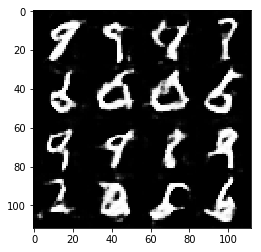

Epoch 1/2... Discriminator Loss: 1.1107... Generator Loss: 0.8833
Epoch 1/2... Discriminator Loss: 0.9731... Generator Loss: 1.4086
Epoch 1/2... Discriminator Loss: 1.4188... Generator Loss: 0.5226
Epoch 1/2... Discriminator Loss: 1.2944... Generator Loss: 2.0170
Epoch 1/2... Discriminator Loss: 1.0652... Generator Loss: 0.8148
Epoch 1/2... Discriminator Loss: 1.0871... Generator Loss: 0.9156
Epoch 1/2... Discriminator Loss: 0.9969... Generator Loss: 1.3492
Epoch 1/2... Discriminator Loss: 1.1968... Generator Loss: 0.6502
Epoch 1/2... Discriminator Loss: 1.2100... Generator Loss: 1.2231
Epoch 1/2... Discriminator Loss: 1.1422... Generator Loss: 0.7727
Epoch 1/2... Discriminator Loss: 1.0671... Generator Loss: 1.1162
Epoch 1/2... Discriminator Loss: 1.0182... Generator Loss: 0.9865
Epoch 1/2... Discriminator Loss: 0.9799... Generator Loss: 1.0304
Epoch 1/2... Discriminator Loss: 0.8812... Generator Loss: 1.4531
Epoch 1/2... Discriminator Loss: 1.3498... Generator Loss: 0.5537
Epoch 1/2.

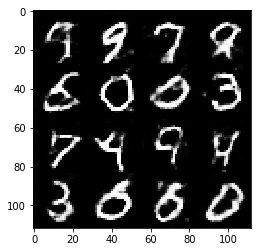

Epoch 1/2... Discriminator Loss: 0.9676... Generator Loss: 0.9807
Epoch 1/2... Discriminator Loss: 1.2845... Generator Loss: 0.6445
Epoch 1/2... Discriminator Loss: 1.2030... Generator Loss: 1.3330
Epoch 1/2... Discriminator Loss: 1.1856... Generator Loss: 0.7023
Epoch 1/2... Discriminator Loss: 1.0000... Generator Loss: 1.1939
Epoch 1/2... Discriminator Loss: 1.0602... Generator Loss: 1.0422
Epoch 1/2... Discriminator Loss: 1.1011... Generator Loss: 0.7950
Epoch 1/2... Discriminator Loss: 1.0839... Generator Loss: 0.9756
Epoch 1/2... Discriminator Loss: 0.9586... Generator Loss: 1.2852
Epoch 1/2... Discriminator Loss: 1.1072... Generator Loss: 0.7646
Epoch 1/2... Discriminator Loss: 1.0546... Generator Loss: 1.0196
Epoch 1/2... Discriminator Loss: 1.0426... Generator Loss: 0.9735
Epoch 1/2... Discriminator Loss: 1.0643... Generator Loss: 1.0735
Epoch 1/2... Discriminator Loss: 1.0803... Generator Loss: 0.8493
Epoch 1/2... Discriminator Loss: 0.9854... Generator Loss: 1.0241
Epoch 1/2.

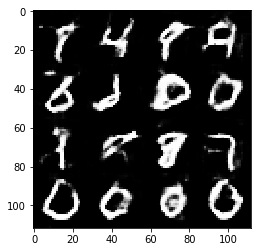

Epoch 1/2... Discriminator Loss: 1.0586... Generator Loss: 1.0663
Epoch 1/2... Discriminator Loss: 0.9407... Generator Loss: 1.3093
Epoch 1/2... Discriminator Loss: 1.2953... Generator Loss: 0.5775
Epoch 1/2... Discriminator Loss: 1.0941... Generator Loss: 1.7685
Epoch 1/2... Discriminator Loss: 1.1097... Generator Loss: 0.7912
Epoch 1/2... Discriminator Loss: 0.9988... Generator Loss: 1.1517
Epoch 1/2... Discriminator Loss: 0.9989... Generator Loss: 0.8869
Epoch 1/2... Discriminator Loss: 0.9513... Generator Loss: 1.8606
Epoch 1/2... Discriminator Loss: 1.6940... Generator Loss: 0.3906
Epoch 1/2... Discriminator Loss: 1.3680... Generator Loss: 2.3146
Epoch 1/2... Discriminator Loss: 1.1109... Generator Loss: 0.8035
Epoch 1/2... Discriminator Loss: 1.1325... Generator Loss: 0.8556
Epoch 1/2... Discriminator Loss: 1.0216... Generator Loss: 1.7548
Epoch 1/2... Discriminator Loss: 1.7955... Generator Loss: 0.3442
Epoch 1/2... Discriminator Loss: 1.1884... Generator Loss: 1.9767
Epoch 1/2.

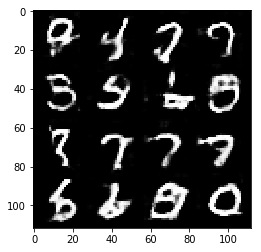

Epoch 1/2... Discriminator Loss: 1.1923... Generator Loss: 0.7341
Epoch 1/2... Discriminator Loss: 1.0209... Generator Loss: 1.1129
Epoch 1/2... Discriminator Loss: 1.1504... Generator Loss: 0.7433
Epoch 1/2... Discriminator Loss: 1.0865... Generator Loss: 1.0821
Epoch 1/2... Discriminator Loss: 0.9994... Generator Loss: 1.0766
Epoch 1/2... Discriminator Loss: 0.9161... Generator Loss: 1.2463
Epoch 1/2... Discriminator Loss: 0.9518... Generator Loss: 0.9580
Epoch 1/2... Discriminator Loss: 0.9488... Generator Loss: 1.1148
Epoch 1/2... Discriminator Loss: 1.0522... Generator Loss: 0.9532
Epoch 1/2... Discriminator Loss: 1.0432... Generator Loss: 1.0014
Epoch 1/2... Discriminator Loss: 0.9570... Generator Loss: 0.9465
Epoch 1/2... Discriminator Loss: 0.9921... Generator Loss: 1.2317
Epoch 1/2... Discriminator Loss: 1.0696... Generator Loss: 0.8676
Epoch 1/2... Discriminator Loss: 0.9619... Generator Loss: 1.3364
Epoch 1/2... Discriminator Loss: 0.9868... Generator Loss: 0.9036
Epoch 1/2.

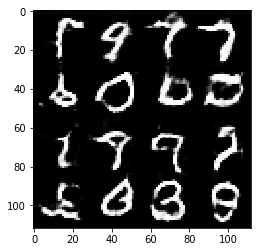

Epoch 1/2... Discriminator Loss: 1.2228... Generator Loss: 2.2184
Epoch 1/2... Discriminator Loss: 1.3052... Generator Loss: 0.6511
Epoch 1/2... Discriminator Loss: 1.2176... Generator Loss: 1.8170
Epoch 1/2... Discriminator Loss: 1.6047... Generator Loss: 0.4303
Epoch 1/2... Discriminator Loss: 1.6648... Generator Loss: 2.6970
Epoch 1/2... Discriminator Loss: 1.5746... Generator Loss: 0.4707
Epoch 1/2... Discriminator Loss: 1.2911... Generator Loss: 1.5966
Epoch 1/2... Discriminator Loss: 1.0378... Generator Loss: 1.0176
Epoch 1/2... Discriminator Loss: 1.1474... Generator Loss: 0.8007
Epoch 1/2... Discriminator Loss: 0.9051... Generator Loss: 1.5082
Epoch 1/2... Discriminator Loss: 1.0319... Generator Loss: 0.9072
Epoch 1/2... Discriminator Loss: 1.1495... Generator Loss: 0.8230
Epoch 1/2... Discriminator Loss: 0.9931... Generator Loss: 1.3482
Epoch 1/2... Discriminator Loss: 1.1170... Generator Loss: 0.7639
Epoch 1/2... Discriminator Loss: 1.0350... Generator Loss: 1.0455
Epoch 1/2.

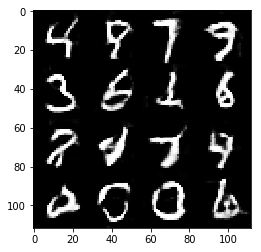

Epoch 1/2... Discriminator Loss: 1.0265... Generator Loss: 0.8688
Epoch 1/2... Discriminator Loss: 0.9604... Generator Loss: 1.4430
Epoch 1/2... Discriminator Loss: 0.9787... Generator Loss: 1.0308
Epoch 1/2... Discriminator Loss: 0.9705... Generator Loss: 0.9974
Epoch 1/2... Discriminator Loss: 0.9510... Generator Loss: 1.0163
Epoch 1/2... Discriminator Loss: 0.8970... Generator Loss: 1.2284
Epoch 1/2... Discriminator Loss: 0.9793... Generator Loss: 1.0673
Epoch 1/2... Discriminator Loss: 0.8964... Generator Loss: 1.2239
Epoch 1/2... Discriminator Loss: 1.0198... Generator Loss: 0.9297
Epoch 1/2... Discriminator Loss: 0.9310... Generator Loss: 1.0697
Epoch 1/2... Discriminator Loss: 0.9952... Generator Loss: 1.1052
Epoch 1/2... Discriminator Loss: 1.0691... Generator Loss: 0.7876
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 1.0451
Epoch 1/2... Discriminator Loss: 0.8712... Generator Loss: 1.1731
Epoch 1/2... Discriminator Loss: 0.9444... Generator Loss: 1.1483
Epoch 1/2.

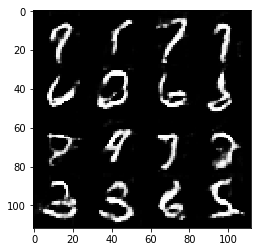

Epoch 2/2... Discriminator Loss: 1.1926... Generator Loss: 0.7289
Epoch 2/2... Discriminator Loss: 0.9058... Generator Loss: 1.4518
Epoch 2/2... Discriminator Loss: 1.5166... Generator Loss: 0.4894
Epoch 2/2... Discriminator Loss: 1.5027... Generator Loss: 2.1384
Epoch 2/2... Discriminator Loss: 1.6575... Generator Loss: 0.3903
Epoch 2/2... Discriminator Loss: 1.3789... Generator Loss: 1.7402
Epoch 2/2... Discriminator Loss: 1.8175... Generator Loss: 0.3540
Epoch 2/2... Discriminator Loss: 1.3493... Generator Loss: 2.2406
Epoch 2/2... Discriminator Loss: 0.9991... Generator Loss: 0.9999
Epoch 2/2... Discriminator Loss: 0.9490... Generator Loss: 1.0566
Epoch 2/2... Discriminator Loss: 0.9015... Generator Loss: 1.2040
Epoch 2/2... Discriminator Loss: 1.1114... Generator Loss: 0.7736
Epoch 2/2... Discriminator Loss: 1.0239... Generator Loss: 1.2960
Epoch 2/2... Discriminator Loss: 1.2289... Generator Loss: 0.6942
Epoch 2/2... Discriminator Loss: 1.2148... Generator Loss: 1.8721
Epoch 2/2.

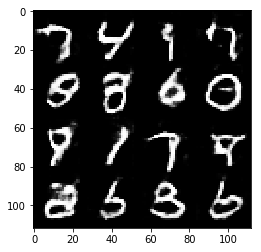

Epoch 2/2... Discriminator Loss: 0.9488... Generator Loss: 1.0903
Epoch 2/2... Discriminator Loss: 1.3395... Generator Loss: 0.5524
Epoch 2/2... Discriminator Loss: 1.3576... Generator Loss: 1.9361
Epoch 2/2... Discriminator Loss: 1.1352... Generator Loss: 0.7229
Epoch 2/2... Discriminator Loss: 1.0207... Generator Loss: 1.2376
Epoch 2/2... Discriminator Loss: 1.0956... Generator Loss: 0.8034
Epoch 2/2... Discriminator Loss: 0.9251... Generator Loss: 1.1567
Epoch 2/2... Discriminator Loss: 0.9821... Generator Loss: 1.0301
Epoch 2/2... Discriminator Loss: 0.9372... Generator Loss: 1.0709
Epoch 2/2... Discriminator Loss: 0.9918... Generator Loss: 1.2251
Epoch 2/2... Discriminator Loss: 1.1387... Generator Loss: 0.6902
Epoch 2/2... Discriminator Loss: 0.9393... Generator Loss: 1.2899
Epoch 2/2... Discriminator Loss: 0.9328... Generator Loss: 1.1086
Epoch 2/2... Discriminator Loss: 1.2539... Generator Loss: 0.6493
Epoch 2/2... Discriminator Loss: 1.0805... Generator Loss: 1.7515
Epoch 2/2.

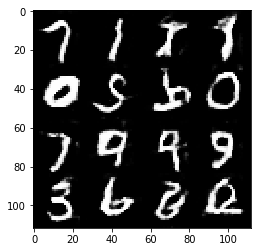

Epoch 2/2... Discriminator Loss: 0.9047... Generator Loss: 1.2150
Epoch 2/2... Discriminator Loss: 1.1592... Generator Loss: 0.6995
Epoch 2/2... Discriminator Loss: 1.0213... Generator Loss: 1.6449
Epoch 2/2... Discriminator Loss: 1.1194... Generator Loss: 0.7821
Epoch 2/2... Discriminator Loss: 0.9698... Generator Loss: 1.5738
Epoch 2/2... Discriminator Loss: 1.0098... Generator Loss: 0.8624
Epoch 2/2... Discriminator Loss: 0.9869... Generator Loss: 1.1387
Epoch 2/2... Discriminator Loss: 0.9366... Generator Loss: 1.1168
Epoch 2/2... Discriminator Loss: 0.9978... Generator Loss: 0.9139
Epoch 2/2... Discriminator Loss: 0.8795... Generator Loss: 1.4694
Epoch 2/2... Discriminator Loss: 1.3531... Generator Loss: 0.5661
Epoch 2/2... Discriminator Loss: 1.0583... Generator Loss: 2.0034
Epoch 2/2... Discriminator Loss: 1.4422... Generator Loss: 0.5564
Epoch 2/2... Discriminator Loss: 0.9427... Generator Loss: 1.7029
Epoch 2/2... Discriminator Loss: 0.9739... Generator Loss: 0.9563
Epoch 2/2.

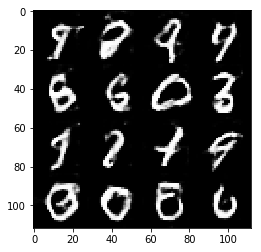

Epoch 2/2... Discriminator Loss: 0.8707... Generator Loss: 1.4380
Epoch 2/2... Discriminator Loss: 1.2622... Generator Loss: 0.6107
Epoch 2/2... Discriminator Loss: 1.0741... Generator Loss: 1.7454
Epoch 2/2... Discriminator Loss: 1.2540... Generator Loss: 0.5977
Epoch 2/2... Discriminator Loss: 0.9196... Generator Loss: 1.6459
Epoch 2/2... Discriminator Loss: 1.1009... Generator Loss: 0.7869
Epoch 2/2... Discriminator Loss: 0.9162... Generator Loss: 1.3183
Epoch 2/2... Discriminator Loss: 0.9209... Generator Loss: 1.0665
Epoch 2/2... Discriminator Loss: 1.1300... Generator Loss: 0.7352
Epoch 2/2... Discriminator Loss: 0.9344... Generator Loss: 1.2526
Epoch 2/2... Discriminator Loss: 0.9761... Generator Loss: 0.9464
Epoch 2/2... Discriminator Loss: 1.3002... Generator Loss: 0.5944
Epoch 2/2... Discriminator Loss: 1.0921... Generator Loss: 2.0025
Epoch 2/2... Discriminator Loss: 1.1168... Generator Loss: 0.7675
Epoch 2/2... Discriminator Loss: 1.0114... Generator Loss: 1.0643
Epoch 2/2.

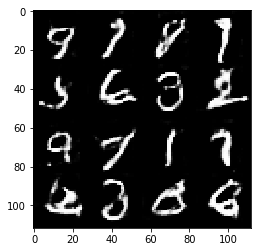

Epoch 2/2... Discriminator Loss: 0.9889... Generator Loss: 1.4567
Epoch 2/2... Discriminator Loss: 1.0186... Generator Loss: 0.8733
Epoch 2/2... Discriminator Loss: 1.0543... Generator Loss: 0.9633
Epoch 2/2... Discriminator Loss: 0.9567... Generator Loss: 1.2550
Epoch 2/2... Discriminator Loss: 0.9221... Generator Loss: 1.0420
Epoch 2/2... Discriminator Loss: 0.9272... Generator Loss: 1.2093
Epoch 2/2... Discriminator Loss: 0.9006... Generator Loss: 1.0797
Epoch 2/2... Discriminator Loss: 0.9456... Generator Loss: 1.0775
Epoch 2/2... Discriminator Loss: 0.8702... Generator Loss: 1.1473
Epoch 2/2... Discriminator Loss: 1.0325... Generator Loss: 0.9044
Epoch 2/2... Discriminator Loss: 0.9967... Generator Loss: 1.1489
Epoch 2/2... Discriminator Loss: 1.0555... Generator Loss: 0.8298
Epoch 2/2... Discriminator Loss: 0.9109... Generator Loss: 1.3673
Epoch 2/2... Discriminator Loss: 1.0052... Generator Loss: 0.8268
Epoch 2/2... Discriminator Loss: 0.9818... Generator Loss: 1.2206
Epoch 2/2.

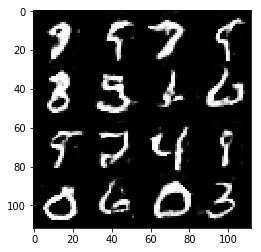

Epoch 2/2... Discriminator Loss: 1.0083... Generator Loss: 0.9918
Epoch 2/2... Discriminator Loss: 1.0923... Generator Loss: 0.8025
Epoch 2/2... Discriminator Loss: 0.8678... Generator Loss: 1.3645
Epoch 2/2... Discriminator Loss: 0.9453... Generator Loss: 0.9782
Epoch 2/2... Discriminator Loss: 1.0664... Generator Loss: 0.8548
Epoch 2/2... Discriminator Loss: 0.9694... Generator Loss: 0.9369
Epoch 2/2... Discriminator Loss: 0.9413... Generator Loss: 1.2894
Epoch 2/2... Discriminator Loss: 0.8875... Generator Loss: 1.1581
Epoch 2/2... Discriminator Loss: 1.0222... Generator Loss: 0.8657
Epoch 2/2... Discriminator Loss: 0.9286... Generator Loss: 1.2454
Epoch 2/2... Discriminator Loss: 0.9212... Generator Loss: 1.0289
Epoch 2/2... Discriminator Loss: 0.8566... Generator Loss: 1.2045
Epoch 2/2... Discriminator Loss: 0.8067... Generator Loss: 1.2627
Epoch 2/2... Discriminator Loss: 1.2250... Generator Loss: 0.6377
Epoch 2/2... Discriminator Loss: 1.0387... Generator Loss: 1.5354
Epoch 2/2.

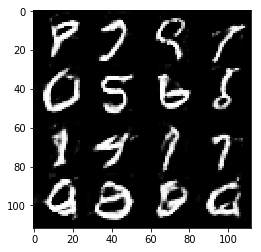

Epoch 2/2... Discriminator Loss: 0.9401... Generator Loss: 1.0260
Epoch 2/2... Discriminator Loss: 0.8568... Generator Loss: 1.3552
Epoch 2/2... Discriminator Loss: 1.2105... Generator Loss: 0.6358
Epoch 2/2... Discriminator Loss: 0.9948... Generator Loss: 1.4330
Epoch 2/2... Discriminator Loss: 1.0454... Generator Loss: 0.8169
Epoch 2/2... Discriminator Loss: 0.8372... Generator Loss: 1.5573
Epoch 2/2... Discriminator Loss: 1.0819... Generator Loss: 0.7896
Epoch 2/2... Discriminator Loss: 0.9477... Generator Loss: 1.2625
Epoch 2/2... Discriminator Loss: 1.0609... Generator Loss: 0.8470
Epoch 2/2... Discriminator Loss: 0.9847... Generator Loss: 1.2925
Epoch 2/2... Discriminator Loss: 0.9158... Generator Loss: 1.0525
Epoch 2/2... Discriminator Loss: 0.8901... Generator Loss: 1.1193
Epoch 2/2... Discriminator Loss: 0.8563... Generator Loss: 1.3056
Epoch 2/2... Discriminator Loss: 1.1599... Generator Loss: 0.6735
Epoch 2/2... Discriminator Loss: 0.8370... Generator Loss: 1.8319
Epoch 2/2.

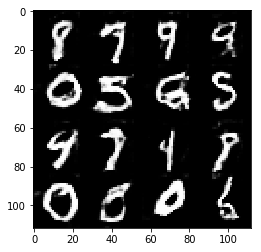

Epoch 2/2... Discriminator Loss: 0.8783... Generator Loss: 1.4651
Epoch 2/2... Discriminator Loss: 1.0160... Generator Loss: 0.8548
Epoch 2/2... Discriminator Loss: 0.8699... Generator Loss: 1.2770
Epoch 2/2... Discriminator Loss: 0.8705... Generator Loss: 1.2186
Epoch 2/2... Discriminator Loss: 1.2106... Generator Loss: 0.6383
Epoch 2/2... Discriminator Loss: 0.9745... Generator Loss: 1.4029
Epoch 2/2... Discriminator Loss: 0.8892... Generator Loss: 1.0803
Epoch 2/2... Discriminator Loss: 1.1142... Generator Loss: 0.8585
Epoch 2/2... Discriminator Loss: 0.8022... Generator Loss: 1.5907
Epoch 2/2... Discriminator Loss: 1.0464... Generator Loss: 0.8522
Epoch 2/2... Discriminator Loss: 1.0237... Generator Loss: 0.9106
Epoch 2/2... Discriminator Loss: 1.0592... Generator Loss: 1.6760
Epoch 2/2... Discriminator Loss: 0.9970... Generator Loss: 0.8911
Epoch 2/2... Discriminator Loss: 1.0502... Generator Loss: 0.8811
Epoch 2/2... Discriminator Loss: 1.0687... Generator Loss: 1.8258
Epoch 2/2.

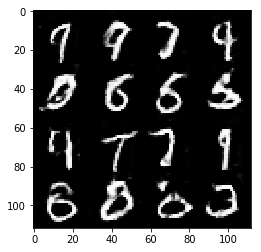

Epoch 2/2... Discriminator Loss: 0.9884... Generator Loss: 1.1717
Epoch 2/2... Discriminator Loss: 1.0759... Generator Loss: 0.7866
Epoch 2/2... Discriminator Loss: 0.8469... Generator Loss: 1.3904
Epoch 2/2... Discriminator Loss: 1.0212... Generator Loss: 0.9188
Epoch 2/2... Discriminator Loss: 0.9744... Generator Loss: 1.0097
Epoch 2/2... Discriminator Loss: 1.0082... Generator Loss: 1.1813
Epoch 2/2... Discriminator Loss: 0.8937... Generator Loss: 1.1597
Epoch 2/2... Discriminator Loss: 0.9922... Generator Loss: 0.9011
Epoch 2/2... Discriminator Loss: 0.8533... Generator Loss: 1.3668
Epoch 2/2... Discriminator Loss: 0.8247... Generator Loss: 1.1874
Epoch 2/2... Discriminator Loss: 1.1268... Generator Loss: 0.7543
Epoch 2/2... Discriminator Loss: 0.9183... Generator Loss: 1.1830
Epoch 2/2... Discriminator Loss: 0.8485... Generator Loss: 1.4728
Epoch 2/2... Discriminator Loss: 1.2124... Generator Loss: 0.6437
Epoch 2/2... Discriminator Loss: 0.9712... Generator Loss: 1.3597
Epoch 2/2.

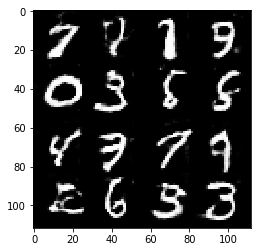

Epoch 2/2... Discriminator Loss: 0.9586... Generator Loss: 0.9943
Epoch 2/2... Discriminator Loss: 0.9734... Generator Loss: 1.0961
Epoch 2/2... Discriminator Loss: 0.9908... Generator Loss: 0.9894
Epoch 2/2... Discriminator Loss: 0.8226... Generator Loss: 1.2720
Epoch 2/2... Discriminator Loss: 0.8927... Generator Loss: 1.0570
Epoch 2/2... Discriminator Loss: 1.0445... Generator Loss: 0.8479
Epoch 2/2... Discriminator Loss: 0.8030... Generator Loss: 1.9784
Epoch 2/2... Discriminator Loss: 1.3838... Generator Loss: 0.5085
Epoch 2/2... Discriminator Loss: 0.9344... Generator Loss: 1.5649
Epoch 2/2... Discriminator Loss: 0.8135... Generator Loss: 1.2417
Epoch 2/2... Discriminator Loss: 0.9236... Generator Loss: 0.9968
Epoch 2/2... Discriminator Loss: 0.9906... Generator Loss: 1.0574
Epoch 2/2... Discriminator Loss: 0.9900... Generator Loss: 0.9772
Epoch 2/2... Discriminator Loss: 0.9407... Generator Loss: 1.2595
Epoch 2/2... Discriminator Loss: 1.0822... Generator Loss: 0.8462
Epoch 2/2.

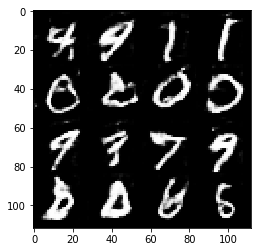

Epoch 2/2... Discriminator Loss: 0.8075... Generator Loss: 1.4416
Epoch 2/2... Discriminator Loss: 1.2557... Generator Loss: 0.6454
Epoch 2/2... Discriminator Loss: 0.9657... Generator Loss: 1.3388
Epoch 2/2... Discriminator Loss: 0.9038... Generator Loss: 1.0715
Epoch 2/2... Discriminator Loss: 0.8494... Generator Loss: 1.1228
Epoch 2/2... Discriminator Loss: 0.9368... Generator Loss: 1.0997
Epoch 2/2... Discriminator Loss: 0.8875... Generator Loss: 1.2586
Epoch 2/2... Discriminator Loss: 0.8789... Generator Loss: 1.1555
Epoch 2/2... Discriminator Loss: 1.0117... Generator Loss: 0.8684
Epoch 2/2... Discriminator Loss: 0.8525... Generator Loss: 1.6625
Epoch 2/2... Discriminator Loss: 1.0819... Generator Loss: 0.7662
Epoch 2/2... Discriminator Loss: 1.0077... Generator Loss: 1.3757
Epoch 2/2... Discriminator Loss: 1.1114... Generator Loss: 0.7376
Epoch 2/2... Discriminator Loss: 0.9395... Generator Loss: 1.3492
Epoch 2/2... Discriminator Loss: 0.9042... Generator Loss: 1.1679
Epoch 2/2.

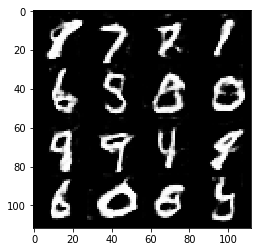

Epoch 2/2... Discriminator Loss: 0.9493... Generator Loss: 1.1743
Epoch 2/2... Discriminator Loss: 0.8007... Generator Loss: 1.5797
Epoch 2/2... Discriminator Loss: 1.2229... Generator Loss: 0.6366
Epoch 2/2... Discriminator Loss: 0.9955... Generator Loss: 1.5998
Epoch 2/2... Discriminator Loss: 0.8752... Generator Loss: 1.0399
Epoch 2/2... Discriminator Loss: 0.9464... Generator Loss: 1.0708
Epoch 2/2... Discriminator Loss: 0.9339... Generator Loss: 1.0495
Epoch 2/2... Discriminator Loss: 1.0042... Generator Loss: 1.0637
Epoch 2/2... Discriminator Loss: 1.0036... Generator Loss: 0.9101
Epoch 2/2... Discriminator Loss: 0.9653... Generator Loss: 1.2330
Epoch 2/2... Discriminator Loss: 1.0563... Generator Loss: 0.7968
Epoch 2/2... Discriminator Loss: 0.8494... Generator Loss: 1.6243
Epoch 2/2... Discriminator Loss: 1.0308... Generator Loss: 0.8466
Epoch 2/2... Discriminator Loss: 0.9501... Generator Loss: 1.0339
Epoch 2/2... Discriminator Loss: 0.9598... Generator Loss: 1.1012
Epoch 2/2.

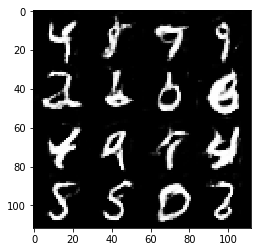

Epoch 2/2... Discriminator Loss: 0.8887... Generator Loss: 1.2279
Epoch 2/2... Discriminator Loss: 1.2168... Generator Loss: 0.6625
Epoch 2/2... Discriminator Loss: 0.9500... Generator Loss: 1.4522
Epoch 2/2... Discriminator Loss: 0.9847... Generator Loss: 0.9303
Epoch 2/2... Discriminator Loss: 0.9001... Generator Loss: 1.1071
Epoch 2/2... Discriminator Loss: 0.8559... Generator Loss: 1.5732
Epoch 2/2... Discriminator Loss: 1.2097... Generator Loss: 0.6477
Epoch 2/2... Discriminator Loss: 0.9057... Generator Loss: 1.3682
Epoch 2/2... Discriminator Loss: 1.1210... Generator Loss: 0.7249
Epoch 2/2... Discriminator Loss: 1.0008... Generator Loss: 1.6406
Epoch 2/2... Discriminator Loss: 0.9442... Generator Loss: 0.9924
Epoch 2/2... Discriminator Loss: 0.9015... Generator Loss: 1.0400
Epoch 2/2... Discriminator Loss: 0.8812... Generator Loss: 1.1374
Epoch 2/2... Discriminator Loss: 0.8795... Generator Loss: 1.1900
Epoch 2/2... Discriminator Loss: 1.2482... Generator Loss: 0.6337
Epoch 2/2.

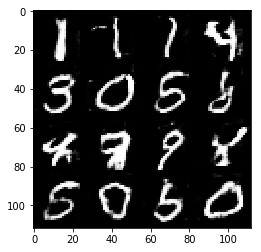

Epoch 2/2... Discriminator Loss: 1.5735... Generator Loss: 0.4520
Epoch 2/2... Discriminator Loss: 1.4621... Generator Loss: 2.2292
Epoch 2/2... Discriminator Loss: 1.6065... Generator Loss: 0.4991
Epoch 2/2... Discriminator Loss: 1.1417... Generator Loss: 1.6190
Epoch 2/2... Discriminator Loss: 1.0549... Generator Loss: 0.9733
Epoch 2/2... Discriminator Loss: 0.9977... Generator Loss: 1.0160
Epoch 2/2... Discriminator Loss: 0.9121... Generator Loss: 1.4385
Epoch 2/2... Discriminator Loss: 0.9115... Generator Loss: 1.1691
Epoch 2/2... Discriminator Loss: 0.9072... Generator Loss: 1.0814
Epoch 2/2... Discriminator Loss: 0.9484... Generator Loss: 1.0308
Epoch 2/2... Discriminator Loss: 0.7780... Generator Loss: 1.5095
Epoch 2/2... Discriminator Loss: 1.0990... Generator Loss: 0.8204
Epoch 2/2... Discriminator Loss: 0.8477... Generator Loss: 1.2815
Epoch 2/2... Discriminator Loss: 1.0303... Generator Loss: 0.8739
Epoch 2/2... Discriminator Loss: 1.0292... Generator Loss: 1.0285
Epoch 2/2.

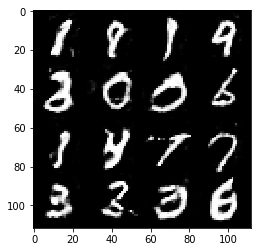

Epoch 2/2... Discriminator Loss: 0.9308... Generator Loss: 1.0623
Epoch 2/2... Discriminator Loss: 0.8929... Generator Loss: 1.2555
Epoch 2/2... Discriminator Loss: 0.9276... Generator Loss: 1.0120
Epoch 2/2... Discriminator Loss: 1.0305... Generator Loss: 0.8289
Epoch 2/2... Discriminator Loss: 0.9018... Generator Loss: 1.4156
Epoch 2/2... Discriminator Loss: 1.0673... Generator Loss: 0.7924
Epoch 2/2... Discriminator Loss: 0.8875... Generator Loss: 1.2760
Epoch 2/2... Discriminator Loss: 1.1358... Generator Loss: 0.7473
Epoch 2/2... Discriminator Loss: 0.9984... Generator Loss: 1.4122
Epoch 2/2... Discriminator Loss: 0.8710... Generator Loss: 1.0667
Epoch 2/2... Discriminator Loss: 0.7732... Generator Loss: 1.3307
Epoch 2/2... Discriminator Loss: 1.0186... Generator Loss: 0.8274
Epoch 2/2... Discriminator Loss: 0.8710... Generator Loss: 1.2709
Epoch 2/2... Discriminator Loss: 0.9706... Generator Loss: 0.9989
Epoch 2/2... Discriminator Loss: 0.8602... Generator Loss: 1.1373
Epoch 2/2.

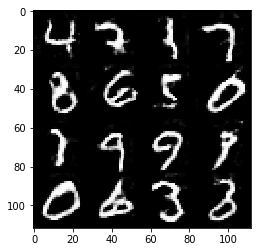

Epoch 2/2... Discriminator Loss: 0.8723... Generator Loss: 1.2274
Epoch 2/2... Discriminator Loss: 0.9876... Generator Loss: 0.9532
Epoch 2/2... Discriminator Loss: 0.9908... Generator Loss: 1.0541
Epoch 2/2... Discriminator Loss: 0.9545... Generator Loss: 1.1912
Epoch 2/2... Discriminator Loss: 1.1046... Generator Loss: 0.7629
Epoch 2/2... Discriminator Loss: 0.8853... Generator Loss: 1.3363
Epoch 2/2... Discriminator Loss: 0.9949... Generator Loss: 0.9332
Epoch 2/2... Discriminator Loss: 0.9003... Generator Loss: 1.4634
Epoch 2/2... Discriminator Loss: 0.8933... Generator Loss: 1.0333
Epoch 2/2... Discriminator Loss: 0.9105... Generator Loss: 1.1524
Epoch 2/2... Discriminator Loss: 0.8388... Generator Loss: 1.2661
Epoch 2/2... Discriminator Loss: 0.9633... Generator Loss: 0.9686
Epoch 2/2... Discriminator Loss: 1.0218... Generator Loss: 0.9753
Epoch 2/2... Discriminator Loss: 0.8697... Generator Loss: 1.4280
Epoch 2/2... Discriminator Loss: 1.1666... Generator Loss: 0.6577
Epoch 2/2.

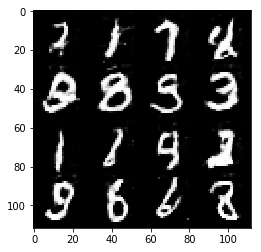

Epoch 2/2... Discriminator Loss: 1.1780... Generator Loss: 0.6599
Epoch 2/2... Discriminator Loss: 0.9721... Generator Loss: 1.8781
Epoch 2/2... Discriminator Loss: 1.3054... Generator Loss: 0.5744
Epoch 2/2... Discriminator Loss: 0.9485... Generator Loss: 1.4053
Epoch 2/2... Discriminator Loss: 0.9568... Generator Loss: 1.0770
Epoch 2/2... Discriminator Loss: 1.0767... Generator Loss: 0.8361
Epoch 2/2... Discriminator Loss: 0.8307... Generator Loss: 1.4752
Epoch 2/2... Discriminator Loss: 1.0482... Generator Loss: 0.8414
Epoch 2/2... Discriminator Loss: 1.0061... Generator Loss: 0.9496
Epoch 2/2... Discriminator Loss: 1.0465... Generator Loss: 0.9289
Epoch 2/2... Discriminator Loss: 0.9185... Generator Loss: 1.3535
Epoch 2/2... Discriminator Loss: 1.1473... Generator Loss: 0.7467
Epoch 2/2... Discriminator Loss: 1.0515... Generator Loss: 0.9659
Epoch 2/2... Discriminator Loss: 0.9512... Generator Loss: 1.1647
Epoch 2/2... Discriminator Loss: 0.9189... Generator Loss: 1.1806
Epoch 2/2.

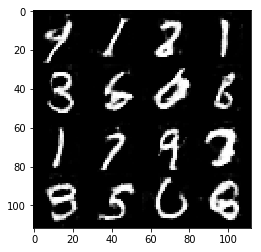

Epoch 2/2... Discriminator Loss: 0.9286... Generator Loss: 1.3600
Epoch 2/2... Discriminator Loss: 0.9846... Generator Loss: 0.9242
Epoch 2/2... Discriminator Loss: 1.0024... Generator Loss: 0.9398
Epoch 2/2... Discriminator Loss: 0.9733... Generator Loss: 1.5061
Epoch 2/2... Discriminator Loss: 0.9183... Generator Loss: 1.0371
Epoch 2/2... Discriminator Loss: 1.0742... Generator Loss: 0.8010
Epoch 2/2... Discriminator Loss: 0.9381... Generator Loss: 1.6776
Epoch 2/2... Discriminator Loss: 1.3390... Generator Loss: 0.5708
Epoch 2/2... Discriminator Loss: 0.9717... Generator Loss: 1.2901
Epoch 2/2... Discriminator Loss: 1.0244... Generator Loss: 1.0330
Epoch 2/2... Discriminator Loss: 0.9405... Generator Loss: 1.2740
Epoch 2/2... Discriminator Loss: 0.8720... Generator Loss: 1.1658
Epoch 2/2... Discriminator Loss: 1.0460... Generator Loss: 0.9078
Epoch 2/2... Discriminator Loss: 1.0165... Generator Loss: 0.9729
Epoch 2/2... Discriminator Loss: 0.9242... Generator Loss: 1.2642
Epoch 2/2.

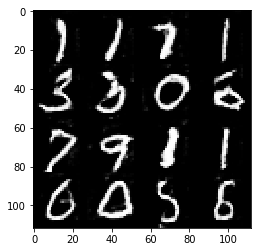

Epoch 2/2... Discriminator Loss: 0.9019... Generator Loss: 1.2198
Epoch 2/2... Discriminator Loss: 0.8639... Generator Loss: 1.2920
Epoch 2/2... Discriminator Loss: 1.0761... Generator Loss: 0.7937
Epoch 2/2... Discriminator Loss: 0.9200... Generator Loss: 1.3005
Epoch 2/2... Discriminator Loss: 0.8932... Generator Loss: 1.1422
Epoch 2/2... Discriminator Loss: 0.8563... Generator Loss: 1.1240
Epoch 2/2... Discriminator Loss: 0.8964... Generator Loss: 1.0747
Epoch 2/2... Discriminator Loss: 0.8440... Generator Loss: 1.3284
Epoch 2/2... Discriminator Loss: 0.9227... Generator Loss: 1.0685
Epoch 2/2... Discriminator Loss: 0.9344... Generator Loss: 1.1056
Epoch 2/2... Discriminator Loss: 0.8711... Generator Loss: 1.0933
Epoch 2/2... Discriminator Loss: 0.9637... Generator Loss: 1.0818
Epoch 2/2... Discriminator Loss: 0.8526... Generator Loss: 1.4291
Epoch 2/2... Discriminator Loss: 0.8150... Generator Loss: 1.1809
Epoch 2/2... Discriminator Loss: 1.1780... Generator Loss: 0.6526
Epoch 2/2.

In [12]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.9160... Generator Loss: 0.0417
Epoch 1/1... Discriminator Loss: 2.2928... Generator Loss: 0.2413
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 0.9842
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.5490
Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 1.1788
Epoch 1/1... Discriminator Loss: 0.8017... Generator Loss: 1.3209
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.5428
Epoch 1/1... Discriminator Loss: 0.5193... Generator Loss: 2.3921
Epoch 1/1... Discriminator Loss: 0.6291... Generator Loss: 1.8910
Epoch 1/1... Discriminator Loss: 0.8206... Generator Loss: 1.2306
Epoch 1/1... Discriminator Loss: 0.7009... Generator Loss: 1.5269
Epoch 1/1... Discriminator Loss: 0.5438... Generator Loss: 2.2514
Epoch 1/1.

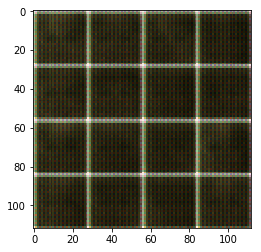

Epoch 1/1... Discriminator Loss: 0.6388... Generator Loss: 1.8929
Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 1.1307
Epoch 1/1... Discriminator Loss: 0.6999... Generator Loss: 2.0317
Epoch 1/1... Discriminator Loss: 0.6349... Generator Loss: 2.0834
Epoch 1/1... Discriminator Loss: 0.9910... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 0.7464... Generator Loss: 2.4709
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 0.7759... Generator Loss: 2.8438
Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 0.7582... Generator Loss: 1.5362
Epoch 1/1... Discriminator Loss: 0.6342... Generator Loss: 2.0785
Epoch 1/1... Discriminator Loss: 0.6869... Generator Loss: 1.7202
Epoch 1/1... Discriminator Loss: 0.8530... Generator Loss: 1.1718
Epoch 1/1... Discriminator Loss: 0.7098... Generator Loss: 1.7367
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 1.1636
Epoch 1/1.

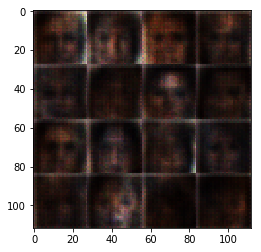

Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 1.2731
Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 0.5065
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 0.9541
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.0067... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 1.0398
Epoch 1/1... Discriminator Loss: 1.7593... Generator Loss: 0.3390
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 2.2002
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.5381
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 1.2840
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 0.9835... Generator Loss: 1.3378
Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 1.2925
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.5896
Epoch 1/1.

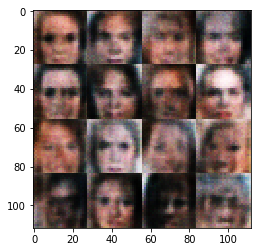

Epoch 1/1... Discriminator Loss: 0.8720... Generator Loss: 1.1689
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 0.9817
Epoch 1/1... Discriminator Loss: 0.7690... Generator Loss: 1.9331
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.5080
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 1.4105
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.0337... Generator Loss: 1.4380
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 0.9961
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 1.0621
Epoch 1/1... Discriminator Loss: 0.8841... Generator Loss: 1.3180
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 1.2272
Epoch 1/1... Discriminator Loss: 0.6944... Generator Loss: 1.7471
Epoch 1/1... Discriminator Loss: 0.7069... Generator Loss: 1.4364
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 2.2840
Epoch 1/1.

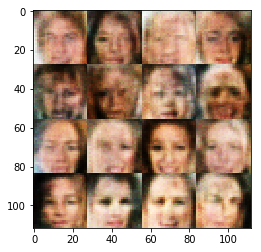

Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 1.9054
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 0.9660... Generator Loss: 1.0651
Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 1.2925
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 1.1684
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 0.9085... Generator Loss: 1.4380
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.5795
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 1.2311
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 1.1648
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 1.4950
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.8924
Epoch 1/1.

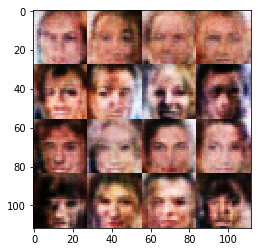

Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 1.7228
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 1.2311
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 1.1623
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 1.0908
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 1.5978
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 1.1929
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.6394
Epoch 1/1.

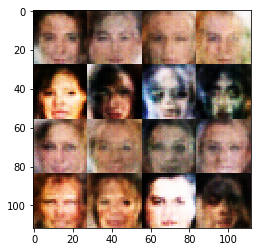

Epoch 1/1... Discriminator Loss: 0.8223... Generator Loss: 1.7402
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 0.9463
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 1.3565
Epoch 1/1... Discriminator Loss: 0.8957... Generator Loss: 1.1881
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 1.5000
Epoch 1/1... Discriminator Loss: 0.9597... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 0.7292... Generator Loss: 1.7834
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.4628
Epoch 1/1... Discriminator Loss: 1.5991... Generator Loss: 3.2656
Epoch 1/1... Discriminator Loss: 1.9754... Generator Loss: 0.2719
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 1.8107
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.5172
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 1.3981
Epoch 1/1.

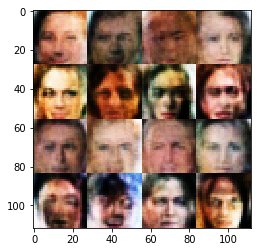

Epoch 1/1... Discriminator Loss: 0.7009... Generator Loss: 1.5427
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 0.8366... Generator Loss: 2.4743
Epoch 1/1... Discriminator Loss: 0.6792... Generator Loss: 1.7291
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 0.8376... Generator Loss: 2.7981
Epoch 1/1... Discriminator Loss: 0.8330... Generator Loss: 1.1395
Epoch 1/1... Discriminator Loss: 0.6544... Generator Loss: 1.8166
Epoch 1/1... Discriminator Loss: 0.7082... Generator Loss: 1.4935
Epoch 1/1... Discriminator Loss: 0.6630... Generator Loss: 1.8958
Epoch 1/1... Discriminator Loss: 0.7730... Generator Loss: 1.3034
Epoch 1/1... Discriminator Loss: 0.7203... Generator Loss: 1.7846
Epoch 1/1... Discriminator Loss: 0.7532... Generator Loss: 1.4843
Epoch 1/1... Discriminator Loss: 0.6694... Generator Loss: 1.8784
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 1.0881
Epoch 1/1.

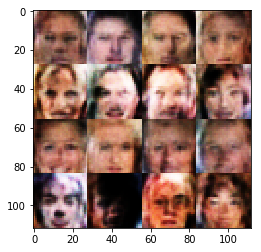

Epoch 1/1... Discriminator Loss: 0.7045... Generator Loss: 2.0724
Epoch 1/1... Discriminator Loss: 0.6622... Generator Loss: 1.8546
Epoch 1/1... Discriminator Loss: 0.5908... Generator Loss: 2.1007
Epoch 1/1... Discriminator Loss: 0.7853... Generator Loss: 1.3021
Epoch 1/1... Discriminator Loss: 0.5841... Generator Loss: 3.7270
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 3.5545
Epoch 1/1... Discriminator Loss: 0.5621... Generator Loss: 2.2113
Epoch 1/1... Discriminator Loss: 0.7772... Generator Loss: 1.1937
Epoch 1/1... Discriminator Loss: 0.5991... Generator Loss: 2.1454
Epoch 1/1... Discriminator Loss: 0.4796... Generator Loss: 3.1590
Epoch 1/1... Discriminator Loss: 2.0418... Generator Loss: 0.2422
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 6.7000
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 0.6801... Generator Loss: 1.7226
Epoch 1/1.

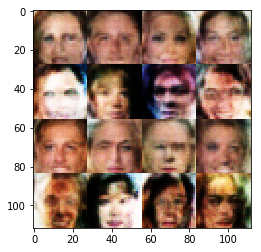

Epoch 1/1... Discriminator Loss: 0.3693... Generator Loss: 5.2778
Epoch 1/1... Discriminator Loss: 0.4673... Generator Loss: 2.8780
Epoch 1/1... Discriminator Loss: 0.7100... Generator Loss: 1.3673
Epoch 1/1... Discriminator Loss: 0.6491... Generator Loss: 2.4280
Epoch 1/1... Discriminator Loss: 0.5238... Generator Loss: 3.1978
Epoch 1/1... Discriminator Loss: 0.7226... Generator Loss: 1.4099
Epoch 1/1... Discriminator Loss: 0.5489... Generator Loss: 2.5701
Epoch 1/1... Discriminator Loss: 0.4187... Generator Loss: 3.5681
Epoch 1/1... Discriminator Loss: 0.7301... Generator Loss: 1.3753
Epoch 1/1... Discriminator Loss: 0.5778... Generator Loss: 5.3305
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 1.7967
Epoch 1/1... Discriminator Loss: 0.7656... Generator Loss: 1.5900
Epoch 1/1... Discriminator Loss: 0.4333... Generator Loss: 3.5161
Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 0.8018
Epoch 1/1.

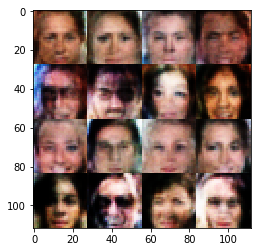

Epoch 1/1... Discriminator Loss: 0.4807... Generator Loss: 2.7294
Epoch 1/1... Discriminator Loss: 0.6147... Generator Loss: 1.9501
Epoch 1/1... Discriminator Loss: 0.5148... Generator Loss: 2.6885
Epoch 1/1... Discriminator Loss: 0.5423... Generator Loss: 2.4908
Epoch 1/1... Discriminator Loss: 0.4012... Generator Loss: 4.8239
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.4804
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 2.5853
Epoch 1/1... Discriminator Loss: 0.4854... Generator Loss: 5.8035
Epoch 1/1... Discriminator Loss: 1.6760... Generator Loss: 0.4268
Epoch 1/1... Discriminator Loss: 0.7333... Generator Loss: 6.6112
Epoch 1/1... Discriminator Loss: 0.7601... Generator Loss: 1.6376
Epoch 1/1... Discriminator Loss: 0.3796... Generator Loss: 5.1409
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 0.5003... Generator Loss: 6.4085
Epoch 1/1... Discriminator Loss: 0.4740... Generator Loss: 3.4280
Epoch 1/1.

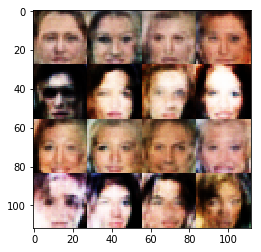

Epoch 1/1... Discriminator Loss: 0.4025... Generator Loss: 3.9955
Epoch 1/1... Discriminator Loss: 0.6783... Generator Loss: 1.5479
Epoch 1/1... Discriminator Loss: 0.5222... Generator Loss: 3.1469
Epoch 1/1... Discriminator Loss: 0.4430... Generator Loss: 5.0106
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 0.5267... Generator Loss: 7.4360
Epoch 1/1... Discriminator Loss: 0.4204... Generator Loss: 4.1521
Epoch 1/1... Discriminator Loss: 0.4510... Generator Loss: 2.5701
Epoch 1/1... Discriminator Loss: 0.5629... Generator Loss: 2.1153
Epoch 1/1... Discriminator Loss: 0.4651... Generator Loss: 3.4150
Epoch 1/1... Discriminator Loss: 0.4231... Generator Loss: 4.3629
Epoch 1/1... Discriminator Loss: 0.7896... Generator Loss: 1.2788
Epoch 1/1... Discriminator Loss: 0.4637... Generator Loss: 5.7746
Epoch 1/1... Discriminator Loss: 0.4643... Generator Loss: 3.0142
Epoch 1/1... Discriminator Loss: 0.4225... Generator Loss: 3.6499
Epoch 1/1.

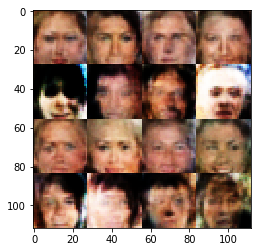

Epoch 1/1... Discriminator Loss: 0.7290... Generator Loss: 1.5544
Epoch 1/1... Discriminator Loss: 0.6124... Generator Loss: 4.7385
Epoch 1/1... Discriminator Loss: 0.4817... Generator Loss: 3.0772
Epoch 1/1... Discriminator Loss: 0.4182... Generator Loss: 3.3051
Epoch 1/1... Discriminator Loss: 0.4630... Generator Loss: 2.6372
Epoch 1/1... Discriminator Loss: 0.4274... Generator Loss: 4.1711
Epoch 1/1... Discriminator Loss: 0.6797... Generator Loss: 1.6636
Epoch 1/1... Discriminator Loss: 0.5693... Generator Loss: 5.0805
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 0.5189... Generator Loss: 6.5561
Epoch 1/1... Discriminator Loss: 0.6364... Generator Loss: 2.1873
Epoch 1/1... Discriminator Loss: 0.3634... Generator Loss: 4.9953
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 0.9870
Epoch 1/1... Discriminator Loss: 0.4915... Generator Loss: 5.4484
Epoch 1/1... Discriminator Loss: 0.6386... Generator Loss: 1.9056
Epoch 1/1.

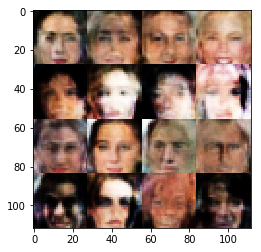

Epoch 1/1... Discriminator Loss: 0.4284... Generator Loss: 4.4907
Epoch 1/1... Discriminator Loss: 0.4968... Generator Loss: 2.9888
Epoch 1/1... Discriminator Loss: 0.5346... Generator Loss: 2.3674
Epoch 1/1... Discriminator Loss: 0.4886... Generator Loss: 4.7649
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 0.7516... Generator Loss: 5.7979
Epoch 1/1... Discriminator Loss: 0.5088... Generator Loss: 2.5722
Epoch 1/1... Discriminator Loss: 0.4940... Generator Loss: 2.6104
Epoch 1/1... Discriminator Loss: 0.4076... Generator Loss: 3.9588
Epoch 1/1... Discriminator Loss: 0.4545... Generator Loss: 3.2572
Epoch 1/1... Discriminator Loss: 0.4566... Generator Loss: 2.9919
Epoch 1/1... Discriminator Loss: 0.3849... Generator Loss: 4.9199
Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 4.9495
Epoch 1/1... Discriminator Loss: 0.4134... Generator Loss: 6.7254
Epoch 1/1.

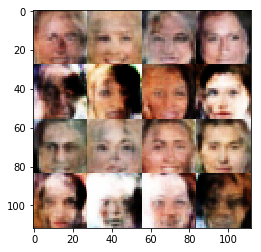

Epoch 1/1... Discriminator Loss: 0.4461... Generator Loss: 4.2216
Epoch 1/1... Discriminator Loss: 0.4965... Generator Loss: 2.6626
Epoch 1/1... Discriminator Loss: 0.5016... Generator Loss: 3.1258
Epoch 1/1... Discriminator Loss: 0.4528... Generator Loss: 3.7848
Epoch 1/1... Discriminator Loss: 0.5336... Generator Loss: 2.5426
Epoch 1/1... Discriminator Loss: 0.4410... Generator Loss: 5.3674
Epoch 1/1... Discriminator Loss: 0.6729... Generator Loss: 1.5511
Epoch 1/1... Discriminator Loss: 0.5067... Generator Loss: 4.2165
Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 4.2994
Epoch 1/1... Discriminator Loss: 0.3919... Generator Loss: 3.6657
Epoch 1/1... Discriminator Loss: 0.7323... Generator Loss: 1.6523
Epoch 1/1... Discriminator Loss: 0.6182... Generator Loss: 4.6478
Epoch 1/1... Discriminator Loss: 0.5077... Generator Loss: 3.0727
Epoch 1/1... Discriminator Loss: 0.4901... Generator Loss: 2.7342
Epoch 1/1... Discriminator Loss: 0.5238... Generator Loss: 2.4090
Epoch 1/1.

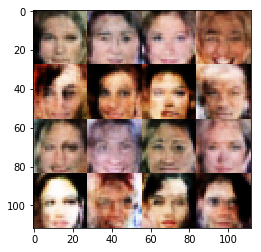

Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 3.6660
Epoch 1/1... Discriminator Loss: 0.4530... Generator Loss: 4.8715
Epoch 1/1... Discriminator Loss: 0.6412... Generator Loss: 2.2690
Epoch 1/1... Discriminator Loss: 0.4464... Generator Loss: 3.3188
Epoch 1/1... Discriminator Loss: 0.6088... Generator Loss: 2.0756
Epoch 1/1... Discriminator Loss: 0.4990... Generator Loss: 4.5809
Epoch 1/1... Discriminator Loss: 0.6454... Generator Loss: 1.9176
Epoch 1/1... Discriminator Loss: 0.5692... Generator Loss: 3.0064
Epoch 1/1... Discriminator Loss: 0.4309... Generator Loss: 4.9774
Epoch 1/1... Discriminator Loss: 0.4743... Generator Loss: 2.8243
Epoch 1/1... Discriminator Loss: 0.4987... Generator Loss: 2.7993
Epoch 1/1... Discriminator Loss: 0.4302... Generator Loss: 4.8634
Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 0.9085
Epoch 1/1... Discriminator Loss: 0.6257... Generator Loss: 3.3994
Epoch 1/1... Discriminator Loss: 0.4655... Generator Loss: 4.2529
Epoch 1/1.

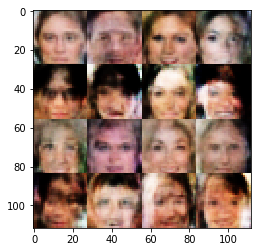

Epoch 1/1... Discriminator Loss: 0.6792... Generator Loss: 2.0760
Epoch 1/1... Discriminator Loss: 0.7514... Generator Loss: 3.6647
Epoch 1/1... Discriminator Loss: 0.3719... Generator Loss: 4.8144
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 3.3461
Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 1.0233
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 1.4028
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 2.4756
Epoch 1/1... Discriminator Loss: 0.5393... Generator Loss: 2.6301
Epoch 1/1... Discriminator Loss: 0.7241... Generator Loss: 1.5716
Epoch 1/1... Discriminator Loss: 0.4204... Generator Loss: 4.1789
Epoch 1/1... Discriminator Loss: 0.8393... Generator Loss: 1.3337
Epoch 1/1... Discriminator Loss: 0.6854... Generator Loss: 4.2181
Epoch 1/1... Discriminator Loss: 0.6958... Generator Loss: 2.3978
Epoch 1/1... Discriminator Loss: 0.5381... Generator Loss: 2.7141
Epoch 1/1.

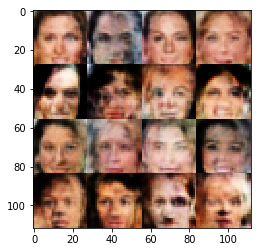

Epoch 1/1... Discriminator Loss: 0.5413... Generator Loss: 2.4016
Epoch 1/1... Discriminator Loss: 0.4684... Generator Loss: 5.1045
Epoch 1/1... Discriminator Loss: 0.4107... Generator Loss: 4.8246
Epoch 1/1... Discriminator Loss: 0.4272... Generator Loss: 3.5537
Epoch 1/1... Discriminator Loss: 0.5614... Generator Loss: 2.3805
Epoch 1/1... Discriminator Loss: 0.5114... Generator Loss: 4.7989
Epoch 1/1... Discriminator Loss: 0.6735... Generator Loss: 1.7471
Epoch 1/1... Discriminator Loss: 0.7570... Generator Loss: 2.6402
Epoch 1/1... Discriminator Loss: 0.4635... Generator Loss: 4.3913
Epoch 1/1... Discriminator Loss: 0.5067... Generator Loss: 2.7554
Epoch 1/1... Discriminator Loss: 0.4124... Generator Loss: 4.0679
Epoch 1/1... Discriminator Loss: 0.4732... Generator Loss: 3.4296
Epoch 1/1... Discriminator Loss: 0.4477... Generator Loss: 3.2755
Epoch 1/1... Discriminator Loss: 0.4638... Generator Loss: 3.8351
Epoch 1/1... Discriminator Loss: 0.4282... Generator Loss: 3.2593
Epoch 1/1.

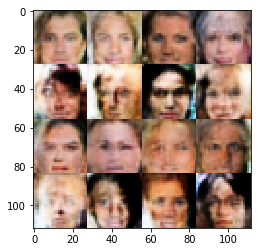

Epoch 1/1... Discriminator Loss: 0.5216... Generator Loss: 2.5620
Epoch 1/1... Discriminator Loss: 0.4556... Generator Loss: 3.4510
Epoch 1/1... Discriminator Loss: 0.4395... Generator Loss: 3.3872
Epoch 1/1... Discriminator Loss: 0.5088... Generator Loss: 3.1808
Epoch 1/1... Discriminator Loss: 0.5495... Generator Loss: 3.3286
Epoch 1/1... Discriminator Loss: 0.4863... Generator Loss: 3.3756
Epoch 1/1... Discriminator Loss: 0.4409... Generator Loss: 3.8962
Epoch 1/1... Discriminator Loss: 0.4489... Generator Loss: 3.3748
Epoch 1/1... Discriminator Loss: 0.5222... Generator Loss: 2.4843
Epoch 1/1... Discriminator Loss: 0.4080... Generator Loss: 4.3863
Epoch 1/1... Discriminator Loss: 0.4759... Generator Loss: 2.6629
Epoch 1/1... Discriminator Loss: 0.6933... Generator Loss: 2.6637
Epoch 1/1... Discriminator Loss: 0.4647... Generator Loss: 3.6909
Epoch 1/1... Discriminator Loss: 0.4982... Generator Loss: 3.3019
Epoch 1/1... Discriminator Loss: 0.5944... Generator Loss: 2.3483
Epoch 1/1.

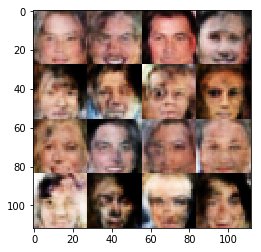

Epoch 1/1... Discriminator Loss: 0.5636... Generator Loss: 2.8220
Epoch 1/1... Discriminator Loss: 0.4124... Generator Loss: 4.7676
Epoch 1/1... Discriminator Loss: 0.5405... Generator Loss: 2.1289
Epoch 1/1... Discriminator Loss: 0.7208... Generator Loss: 2.2676
Epoch 1/1... Discriminator Loss: 0.5636... Generator Loss: 2.5505
Epoch 1/1... Discriminator Loss: 0.6682... Generator Loss: 1.8507
Epoch 1/1... Discriminator Loss: 0.6164... Generator Loss: 2.4764
Epoch 1/1... Discriminator Loss: 0.4986... Generator Loss: 2.5691
Epoch 1/1... Discriminator Loss: 0.4466... Generator Loss: 3.5953
Epoch 1/1... Discriminator Loss: 0.4026... Generator Loss: 4.6668
Epoch 1/1... Discriminator Loss: 0.9331... Generator Loss: 1.0576
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 3.1602
Epoch 1/1... Discriminator Loss: 0.3941... Generator Loss: 4.4316
Epoch 1/1... Discriminator Loss: 0.5492... Generator Loss: 2.2017
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 2.9921
Epoch 1/1.

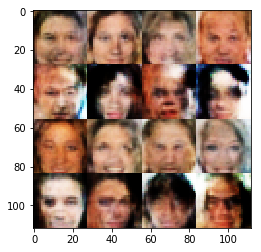

Epoch 1/1... Discriminator Loss: 0.5853... Generator Loss: 2.5350
Epoch 1/1... Discriminator Loss: 0.5104... Generator Loss: 3.2006
Epoch 1/1... Discriminator Loss: 0.5804... Generator Loss: 2.5504
Epoch 1/1... Discriminator Loss: 0.5690... Generator Loss: 2.4757
Epoch 1/1... Discriminator Loss: 0.5841... Generator Loss: 3.0908
Epoch 1/1... Discriminator Loss: 0.5221... Generator Loss: 2.8359
Epoch 1/1... Discriminator Loss: 0.5028... Generator Loss: 2.6251
Epoch 1/1... Discriminator Loss: 0.5809... Generator Loss: 2.5776
Epoch 1/1... Discriminator Loss: 0.6812... Generator Loss: 3.6177
Epoch 1/1... Discriminator Loss: 0.4981... Generator Loss: 2.9694
Epoch 1/1... Discriminator Loss: 0.6152... Generator Loss: 1.9824
Epoch 1/1... Discriminator Loss: 0.6167... Generator Loss: 2.9654
Epoch 1/1... Discriminator Loss: 0.4776... Generator Loss: 4.0201
Epoch 1/1... Discriminator Loss: 0.7166... Generator Loss: 1.7012
Epoch 1/1... Discriminator Loss: 0.6455... Generator Loss: 2.6266
Epoch 1/1.

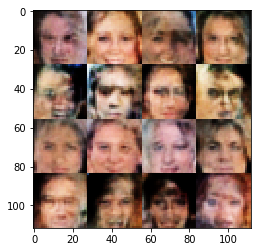

Epoch 1/1... Discriminator Loss: 0.4133... Generator Loss: 3.5826
Epoch 1/1... Discriminator Loss: 0.5016... Generator Loss: 3.4783
Epoch 1/1... Discriminator Loss: 0.4681... Generator Loss: 4.4854
Epoch 1/1... Discriminator Loss: 0.4118... Generator Loss: 4.2425
Epoch 1/1... Discriminator Loss: 0.4235... Generator Loss: 3.4208
Epoch 1/1... Discriminator Loss: 0.4671... Generator Loss: 3.7156
Epoch 1/1... Discriminator Loss: 0.4073... Generator Loss: 4.6803
Epoch 1/1... Discriminator Loss: 0.5505... Generator Loss: 2.5009
Epoch 1/1... Discriminator Loss: 0.5902... Generator Loss: 2.5679
Epoch 1/1... Discriminator Loss: 0.4734... Generator Loss: 3.2012
Epoch 1/1... Discriminator Loss: 0.4163... Generator Loss: 3.8760
Epoch 1/1... Discriminator Loss: 0.4325... Generator Loss: 3.0694
Epoch 1/1... Discriminator Loss: 0.5198... Generator Loss: 3.2110
Epoch 1/1... Discriminator Loss: 0.5143... Generator Loss: 2.7196
Epoch 1/1... Discriminator Loss: 0.5067... Generator Loss: 2.8952
Epoch 1/1.

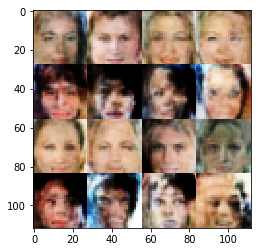

Epoch 1/1... Discriminator Loss: 0.6993... Generator Loss: 1.9548
Epoch 1/1... Discriminator Loss: 0.6858... Generator Loss: 5.4055
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 1.3677
Epoch 1/1... Discriminator Loss: 1.6222... Generator Loss: 2.5885
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.9429... Generator Loss: 2.9275
Epoch 1/1... Discriminator Loss: 1.7911... Generator Loss: 0.3766
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 3.5556
Epoch 1/1... Discriminator Loss: 0.8803... Generator Loss: 1.7728
Epoch 1/1... Discriminator Loss: 0.5929... Generator Loss: 2.9497
Epoch 1/1... Discriminator Loss: 0.6541... Generator Loss: 1.9901
Epoch 1/1... Discriminator Loss: 0.7000... Generator Loss: 2.1469
Epoch 1/1... Discriminator Loss: 0.5094... Generator Loss: 3.0300
Epoch 1/1... Discriminator Loss: 0.5708... Generator Loss: 2.7431
Epoch 1/1... Discriminator Loss: 0.5899... Generator Loss: 2.0881
Epoch 1/1.

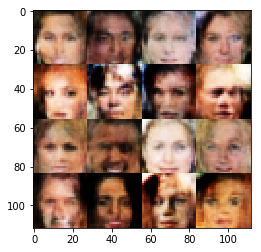

Epoch 1/1... Discriminator Loss: 0.4112... Generator Loss: 4.3973
Epoch 1/1... Discriminator Loss: 0.4641... Generator Loss: 2.6320
Epoch 1/1... Discriminator Loss: 0.5596... Generator Loss: 2.7935
Epoch 1/1... Discriminator Loss: 0.5791... Generator Loss: 2.4605
Epoch 1/1... Discriminator Loss: 0.4408... Generator Loss: 4.4266
Epoch 1/1... Discriminator Loss: 0.5688... Generator Loss: 2.3073
Epoch 1/1... Discriminator Loss: 0.5439... Generator Loss: 3.1831
Epoch 1/1... Discriminator Loss: 0.5752... Generator Loss: 2.2788
Epoch 1/1... Discriminator Loss: 0.6660... Generator Loss: 1.9596
Epoch 1/1... Discriminator Loss: 0.4331... Generator Loss: 4.2264
Epoch 1/1... Discriminator Loss: 0.4033... Generator Loss: 4.3884
Epoch 1/1... Discriminator Loss: 0.5335... Generator Loss: 2.7693
Epoch 1/1... Discriminator Loss: 0.4890... Generator Loss: 3.3687
Epoch 1/1... Discriminator Loss: 0.3975... Generator Loss: 5.7205
Epoch 1/1... Discriminator Loss: 0.5618... Generator Loss: 2.4042
Epoch 1/1.

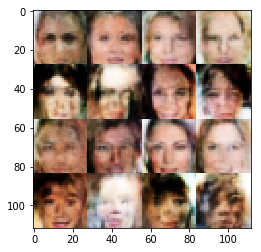

Epoch 1/1... Discriminator Loss: 0.4813... Generator Loss: 4.3562
Epoch 1/1... Discriminator Loss: 0.7245... Generator Loss: 1.4416
Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 2.0746
Epoch 1/1... Discriminator Loss: 0.6107... Generator Loss: 1.8625
Epoch 1/1... Discriminator Loss: 0.6285... Generator Loss: 2.3900
Epoch 1/1... Discriminator Loss: 0.8023... Generator Loss: 1.3739
Epoch 1/1... Discriminator Loss: 0.6866... Generator Loss: 2.1141
Epoch 1/1... Discriminator Loss: 0.6027... Generator Loss: 2.1961
Epoch 1/1... Discriminator Loss: 0.5282... Generator Loss: 2.8325
Epoch 1/1... Discriminator Loss: 0.4969... Generator Loss: 3.9771
Epoch 1/1... Discriminator Loss: 0.5950... Generator Loss: 2.0295
Epoch 1/1... Discriminator Loss: 0.4619... Generator Loss: 4.3849
Epoch 1/1... Discriminator Loss: 0.4221... Generator Loss: 3.6627
Epoch 1/1... Discriminator Loss: 0.6381... Generator Loss: 2.1358
Epoch 1/1... Discriminator Loss: 0.5827... Generator Loss: 2.6984
Epoch 1/1.

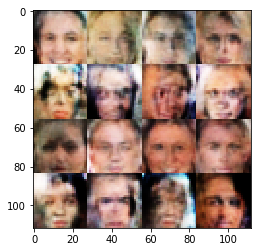

Epoch 1/1... Discriminator Loss: 1.5598... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 2.1981
Epoch 1/1... Discriminator Loss: 1.6725... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 1.9759
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 0.7638... Generator Loss: 1.5797
Epoch 1/1... Discriminator Loss: 0.6954... Generator Loss: 2.7099
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 1.5316
Epoch 1/1... Discriminator Loss: 0.9040... Generator Loss: 1.3981
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 1.1598
Epoch 1/1... Discriminator Loss: 0.8016... Generator Loss: 1.8750
Epoch 1/1... Discriminator Loss: 0.6609... Generator Loss: 1.9441
Epoch 1/1... Discriminator Loss: 0.6963... Generator Loss: 2.1043
Epoch 1/1... Discriminator Loss: 0.6567... Generator Loss: 2.7769
Epoch 1/1.

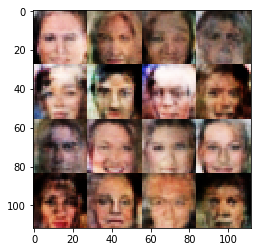

Epoch 1/1... Discriminator Loss: 0.4296... Generator Loss: 4.7060
Epoch 1/1... Discriminator Loss: 0.6986... Generator Loss: 1.6551
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 1.1912
Epoch 1/1... Discriminator Loss: 0.6467... Generator Loss: 3.9313
Epoch 1/1... Discriminator Loss: 0.4492... Generator Loss: 3.6620
Epoch 1/1... Discriminator Loss: 0.6315... Generator Loss: 2.1611
Epoch 1/1... Discriminator Loss: 0.5681... Generator Loss: 3.8746
Epoch 1/1... Discriminator Loss: 0.4194... Generator Loss: 3.7622
Epoch 1/1... Discriminator Loss: 0.7602... Generator Loss: 1.5817
Epoch 1/1... Discriminator Loss: 0.7676... Generator Loss: 2.1438
Epoch 1/1... Discriminator Loss: 0.7273... Generator Loss: 1.3982
Epoch 1/1... Discriminator Loss: 0.6597... Generator Loss: 2.1394
Epoch 1/1... Discriminator Loss: 0.4829... Generator Loss: 4.4343
Epoch 1/1... Discriminator Loss: 0.6487... Generator Loss: 2.3060
Epoch 1/1... Discriminator Loss: 0.5717... Generator Loss: 3.4415
Epoch 1/1.

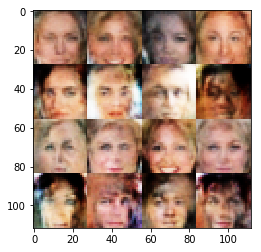

Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 2.3538
Epoch 1/1... Discriminator Loss: 1.8920... Generator Loss: 0.3189
Epoch 1/1... Discriminator Loss: 2.0856... Generator Loss: 3.6162
Epoch 1/1... Discriminator Loss: 3.6653... Generator Loss: 0.0925
Epoch 1/1... Discriminator Loss: 6.0378... Generator Loss: 7.9154
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 1.3413
Epoch 1/1... Discriminator Loss: 2.1227... Generator Loss: 0.4292
Epoch 1/1... Discriminator Loss: 4.1396... Generator Loss: 4.6829
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.9744
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 1.0826
Epoch 1/1... Discriminator Loss: 2.1360... Generator Loss: 1.4771
Epoch 1/1... Discriminator Loss: 1.8134... Generator Loss: 1.3254
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 1.0301
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 2.0578
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.5856
Epoch 1/1.

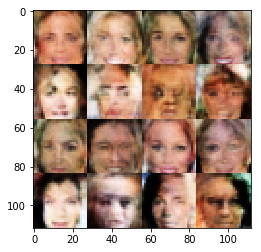

Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 1.2701
Epoch 1/1... Discriminator Loss: 0.5369... Generator Loss: 3.1033
Epoch 1/1... Discriminator Loss: 0.6650... Generator Loss: 2.1813
Epoch 1/1... Discriminator Loss: 0.5050... Generator Loss: 3.6464
Epoch 1/1... Discriminator Loss: 0.7354... Generator Loss: 1.6441
Epoch 1/1... Discriminator Loss: 0.6333... Generator Loss: 2.6059
Epoch 1/1... Discriminator Loss: 0.7908... Generator Loss: 1.4970
Epoch 1/1... Discriminator Loss: 0.5254... Generator Loss: 3.4133
Epoch 1/1... Discriminator Loss: 0.4710... Generator Loss: 3.3782
Epoch 1/1... Discriminator Loss: 0.6861... Generator Loss: 2.0995
Epoch 1/1... Discriminator Loss: 0.5601... Generator Loss: 2.6888
Epoch 1/1... Discriminator Loss: 0.7234... Generator Loss: 1.6186
Epoch 1/1... Discriminator Loss: 0.4534... Generator Loss: 4.1744
Epoch 1/1... Discriminator Loss: 0.6832... Generator Loss: 2.0793
Epoch 1/1... Discriminator Loss: 0.6044... Generator Loss: 2.1167
Epoch 1/1.

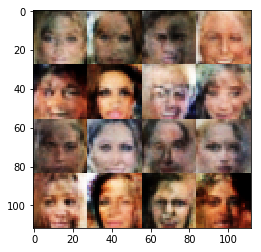

Epoch 1/1... Discriminator Loss: 0.5137... Generator Loss: 2.9884
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 1.0835
Epoch 1/1... Discriminator Loss: 0.6584... Generator Loss: 2.3970
Epoch 1/1... Discriminator Loss: 0.7729... Generator Loss: 1.4819
Epoch 1/1... Discriminator Loss: 0.5283... Generator Loss: 3.0306
Epoch 1/1... Discriminator Loss: 0.4808... Generator Loss: 3.5943
Epoch 1/1... Discriminator Loss: 0.5454... Generator Loss: 2.6025
Epoch 1/1... Discriminator Loss: 0.5856... Generator Loss: 2.3793
Epoch 1/1... Discriminator Loss: 0.4776... Generator Loss: 3.7674
Epoch 1/1... Discriminator Loss: 0.4809... Generator Loss: 3.8360
Epoch 1/1... Discriminator Loss: 0.7386... Generator Loss: 1.3499
Epoch 1/1... Discriminator Loss: 0.6344... Generator Loss: 3.0271
Epoch 1/1... Discriminator Loss: 0.5667... Generator Loss: 2.5141
Epoch 1/1... Discriminator Loss: 0.5473... Generator Loss: 2.5760
Epoch 1/1... Discriminator Loss: 0.4911... Generator Loss: 3.5229
Epoch 1/1.

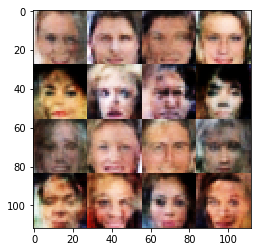

Epoch 1/1... Discriminator Loss: 0.8000... Generator Loss: 1.6161
Epoch 1/1... Discriminator Loss: 0.7510... Generator Loss: 1.7228
Epoch 1/1... Discriminator Loss: 0.7403... Generator Loss: 1.7196
Epoch 1/1... Discriminator Loss: 0.9702... Generator Loss: 0.9313
Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 1.3474
Epoch 1/1... Discriminator Loss: 0.6136... Generator Loss: 3.8121
Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 1.4387
Epoch 1/1... Discriminator Loss: 0.5845... Generator Loss: 3.1073
Epoch 1/1... Discriminator Loss: 0.5886... Generator Loss: 3.4502
Epoch 1/1... Discriminator Loss: 0.7441... Generator Loss: 1.7715
Epoch 1/1... Discriminator Loss: 0.5534... Generator Loss: 3.5069
Epoch 1/1... Discriminator Loss: 0.5118... Generator Loss: 3.2751
Epoch 1/1... Discriminator Loss: 0.8609... Generator Loss: 1.1437
Epoch 1/1... Discriminator Loss: 0.8891... Generator Loss: 1.8646
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 0.8903
Epoch 1/1.

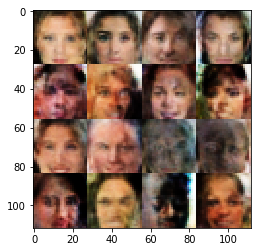

Epoch 1/1... Discriminator Loss: 0.9977... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 0.9126... Generator Loss: 2.4301
Epoch 1/1... Discriminator Loss: 0.6408... Generator Loss: 1.9154
Epoch 1/1... Discriminator Loss: 0.6115... Generator Loss: 2.6770
Epoch 1/1... Discriminator Loss: 0.5190... Generator Loss: 3.3588
Epoch 1/1... Discriminator Loss: 0.4739... Generator Loss: 2.8542
Epoch 1/1... Discriminator Loss: 0.6220... Generator Loss: 1.8723
Epoch 1/1... Discriminator Loss: 0.6005... Generator Loss: 2.8505
Epoch 1/1... Discriminator Loss: 0.5035... Generator Loss: 3.8091
Epoch 1/1... Discriminator Loss: 0.7616... Generator Loss: 1.6618
Epoch 1/1... Discriminator Loss: 0.5810... Generator Loss: 2.2625
Epoch 1/1... Discriminator Loss: 0.5627... Generator Loss: 2.8642
Epoch 1/1... Discriminator Loss: 0.5420... Generator Loss: 2.8205
Epoch 1/1... Discriminator Loss: 0.7125... Generator Loss: 2.1247
Epoch 1/1... Discriminator Loss: 0.5222... Generator Loss: 2.8746
Epoch 1/1.

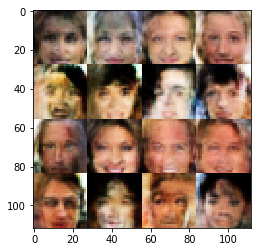

Epoch 1/1... Discriminator Loss: 0.6441... Generator Loss: 1.9171
Epoch 1/1... Discriminator Loss: 0.6876... Generator Loss: 1.9193
Epoch 1/1... Discriminator Loss: 0.5007... Generator Loss: 4.4991
Epoch 1/1... Discriminator Loss: 0.5589... Generator Loss: 2.1720
Epoch 1/1... Discriminator Loss: 0.5537... Generator Loss: 3.0186
Epoch 1/1... Discriminator Loss: 0.5262... Generator Loss: 2.7683
Epoch 1/1... Discriminator Loss: 0.5292... Generator Loss: 2.2804
Epoch 1/1... Discriminator Loss: 0.4845... Generator Loss: 3.4897
Epoch 1/1... Discriminator Loss: 0.5622... Generator Loss: 2.5417
Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 1.3364
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 2.0482
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 0.9840
Epoch 1/1... Discriminator Loss: 0.8148... Generator Loss: 2.5250
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 0.9125
Epoch 1/1... Discriminator Loss: 0.7683... Generator Loss: 3.0666
Epoch 1/1.

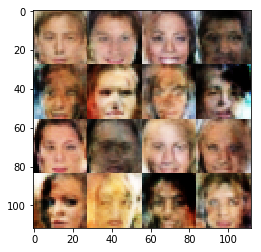

Epoch 1/1... Discriminator Loss: 0.7416... Generator Loss: 2.0025
Epoch 1/1... Discriminator Loss: 0.8051... Generator Loss: 1.3791
Epoch 1/1... Discriminator Loss: 0.6018... Generator Loss: 2.4130
Epoch 1/1... Discriminator Loss: 0.5163... Generator Loss: 4.7698
Epoch 1/1... Discriminator Loss: 0.6499... Generator Loss: 1.9868
Epoch 1/1... Discriminator Loss: 0.7556... Generator Loss: 1.6392
Epoch 1/1... Discriminator Loss: 0.6852... Generator Loss: 2.1790
Epoch 1/1... Discriminator Loss: 0.6547... Generator Loss: 1.8241
Epoch 1/1... Discriminator Loss: 0.7907... Generator Loss: 1.3708
Epoch 1/1... Discriminator Loss: 0.7888... Generator Loss: 1.4618
Epoch 1/1... Discriminator Loss: 0.9027... Generator Loss: 1.1828
Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 1.2474
Epoch 1/1... Discriminator Loss: 0.9133... Generator Loss: 1.0629
Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 0.8534... Generator Loss: 1.4938
Epoch 1/1.

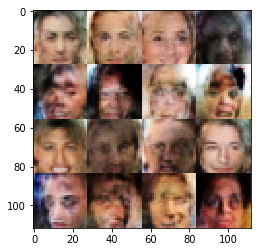

Epoch 1/1... Discriminator Loss: 0.6280... Generator Loss: 3.0105
Epoch 1/1... Discriminator Loss: 0.5101... Generator Loss: 3.0519
Epoch 1/1... Discriminator Loss: 0.5743... Generator Loss: 2.2085
Epoch 1/1... Discriminator Loss: 0.5141... Generator Loss: 3.2877
Epoch 1/1... Discriminator Loss: 0.4137... Generator Loss: 4.2494
Epoch 1/1... Discriminator Loss: 0.6183... Generator Loss: 2.5630
Epoch 1/1... Discriminator Loss: 0.7313... Generator Loss: 2.2535
Epoch 1/1... Discriminator Loss: 0.6792... Generator Loss: 2.2204
Epoch 1/1... Discriminator Loss: 0.9321... Generator Loss: 1.0380
Epoch 1/1... Discriminator Loss: 0.7203... Generator Loss: 1.6584
Epoch 1/1... Discriminator Loss: 0.8186... Generator Loss: 1.1509
Epoch 1/1... Discriminator Loss: 0.6269... Generator Loss: 2.1476
Epoch 1/1... Discriminator Loss: 0.4585... Generator Loss: 3.6836
Epoch 1/1... Discriminator Loss: 0.6478... Generator Loss: 2.1428
Epoch 1/1... Discriminator Loss: 0.5139... Generator Loss: 3.1051
Epoch 1/1.

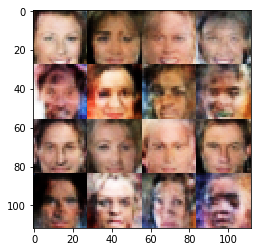

Epoch 1/1... Discriminator Loss: 0.5338... Generator Loss: 2.8996
Epoch 1/1... Discriminator Loss: 0.6114... Generator Loss: 2.4722
Epoch 1/1... Discriminator Loss: 0.6424... Generator Loss: 2.0997
Epoch 1/1... Discriminator Loss: 0.5324... Generator Loss: 2.4640
Epoch 1/1... Discriminator Loss: 0.6000... Generator Loss: 2.1459
Epoch 1/1... Discriminator Loss: 0.6405... Generator Loss: 2.3006
Epoch 1/1... Discriminator Loss: 0.5370... Generator Loss: 3.0734
Epoch 1/1... Discriminator Loss: 0.6283... Generator Loss: 1.8049
Epoch 1/1... Discriminator Loss: 0.5179... Generator Loss: 4.1074
Epoch 1/1... Discriminator Loss: 0.6541... Generator Loss: 2.1323
Epoch 1/1... Discriminator Loss: 0.5349... Generator Loss: 3.7365
Epoch 1/1... Discriminator Loss: 0.6186... Generator Loss: 2.3890
Epoch 1/1... Discriminator Loss: 0.5682... Generator Loss: 2.4483
Epoch 1/1... Discriminator Loss: 0.8442... Generator Loss: 1.3041
Epoch 1/1... Discriminator Loss: 0.6317... Generator Loss: 2.4402
Epoch 1/1.

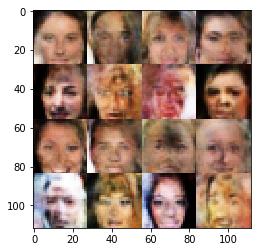

Epoch 1/1... Discriminator Loss: 0.9218... Generator Loss: 1.4594
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 0.9078... Generator Loss: 1.5530
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.1231
Epoch 1/1... Discriminator Loss: 0.9106... Generator Loss: 1.3304
Epoch 1/1... Discriminator Loss: 0.8866... Generator Loss: 1.4124
Epoch 1/1... Discriminator Loss: 0.8981... Generator Loss: 1.5494
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 0.9853
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 1.1622
Epoch 1/1... Discriminator Loss: 0.8998... Generator Loss: 1.3722
Epoch 1/1... Discriminator Loss: 1.0065... Generator Loss: 1.0842
Epoch 1/1... Discriminator Loss: 0.7388... Generator Loss: 1.6916
Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 1.5617
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 1.4392
Epoch 1/1.

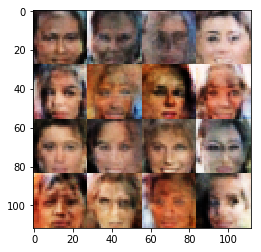

Epoch 1/1... Discriminator Loss: 0.8434... Generator Loss: 1.2660
Epoch 1/1... Discriminator Loss: 0.7800... Generator Loss: 1.7409
Epoch 1/1... Discriminator Loss: 0.5934... Generator Loss: 2.4633
Epoch 1/1... Discriminator Loss: 0.6750... Generator Loss: 2.2020
Epoch 1/1... Discriminator Loss: 0.6386... Generator Loss: 2.6048
Epoch 1/1... Discriminator Loss: 0.6206... Generator Loss: 2.2228
Epoch 1/1... Discriminator Loss: 0.5826... Generator Loss: 2.2534
Epoch 1/1... Discriminator Loss: 0.6388... Generator Loss: 2.2006
Epoch 1/1... Discriminator Loss: 0.5570... Generator Loss: 2.9617
Epoch 1/1... Discriminator Loss: 0.7697... Generator Loss: 1.6663
Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 1.3847
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 1.4045
Epoch 1/1... Discriminator Loss: 0.8797... Generator Loss: 1.0866
Epoch 1/1... Discriminator Loss: 0.8469... Generator Loss: 1.2157
Epoch 1/1... Discriminator Loss: 0.7233... Generator Loss: 2.4343
Epoch 1/1.

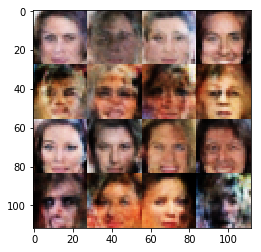

Epoch 1/1... Discriminator Loss: 0.6698... Generator Loss: 1.9119
Epoch 1/1... Discriminator Loss: 0.7794... Generator Loss: 1.4975
Epoch 1/1... Discriminator Loss: 0.7238... Generator Loss: 1.3890
Epoch 1/1... Discriminator Loss: 0.5938... Generator Loss: 3.1884
Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 3.9348
Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 1.0181
Epoch 1/1... Discriminator Loss: 0.8006... Generator Loss: 1.6464
Epoch 1/1... Discriminator Loss: 0.6806... Generator Loss: 2.0604
Epoch 1/1... Discriminator Loss: 0.7876... Generator Loss: 1.1972
Epoch 1/1... Discriminator Loss: 0.8297... Generator Loss: 1.3647
Epoch 1/1... Discriminator Loss: 0.6668... Generator Loss: 1.8859
Epoch 1/1... Discriminator Loss: 0.5237... Generator Loss: 2.9162
Epoch 1/1... Discriminator Loss: 0.6171... Generator Loss: 1.9619
Epoch 1/1... Discriminator Loss: 0.8817... Generator Loss: 1.2434
Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 1.9403
Epoch 1/1.

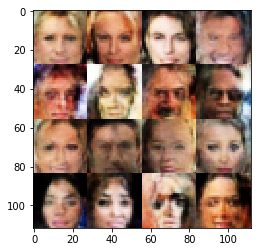

Epoch 1/1... Discriminator Loss: 0.8333... Generator Loss: 1.2555
Epoch 1/1... Discriminator Loss: 0.8107... Generator Loss: 1.6768
Epoch 1/1... Discriminator Loss: 0.7453... Generator Loss: 1.8516
Epoch 1/1... Discriminator Loss: 0.6477... Generator Loss: 2.1083
Epoch 1/1... Discriminator Loss: 0.6023... Generator Loss: 2.4581
Epoch 1/1... Discriminator Loss: 0.6262... Generator Loss: 2.1594
Epoch 1/1... Discriminator Loss: 0.4420... Generator Loss: 3.1640
Epoch 1/1... Discriminator Loss: 0.5779... Generator Loss: 2.4355
Epoch 1/1... Discriminator Loss: 0.6053... Generator Loss: 2.3349
Epoch 1/1... Discriminator Loss: 0.5284... Generator Loss: 2.7473
Epoch 1/1... Discriminator Loss: 0.6737... Generator Loss: 1.7716
Epoch 1/1... Discriminator Loss: 0.7930... Generator Loss: 1.4469
Epoch 1/1... Discriminator Loss: 0.8880... Generator Loss: 0.9995
Epoch 1/1... Discriminator Loss: 0.6698... Generator Loss: 2.4208
Epoch 1/1... Discriminator Loss: 0.6567... Generator Loss: 2.4285
Epoch 1/1.

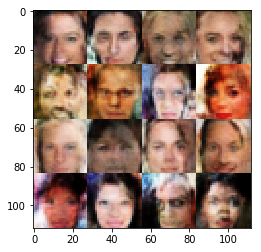

Epoch 1/1... Discriminator Loss: 0.6633... Generator Loss: 2.2927
Epoch 1/1... Discriminator Loss: 0.7646... Generator Loss: 1.5791
Epoch 1/1... Discriminator Loss: 0.5865... Generator Loss: 1.9022
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 1.6374
Epoch 1/1... Discriminator Loss: 0.8522... Generator Loss: 1.3090
Epoch 1/1... Discriminator Loss: 0.7418... Generator Loss: 1.8192
Epoch 1/1... Discriminator Loss: 0.7627... Generator Loss: 1.7894
Epoch 1/1... Discriminator Loss: 0.4463... Generator Loss: 3.5398
Epoch 1/1... Discriminator Loss: 0.5642... Generator Loss: 3.2492
Epoch 1/1... Discriminator Loss: 0.4931... Generator Loss: 3.0994
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 1.8595
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 0.7719... Generator Loss: 3.1562
Epoch 1/1... Discriminator Loss: 0.5787... Generator Loss: 2.6575
Epoch 1/1... Discriminator Loss: 0.6025... Generator Loss: 2.2110
Epoch 1/1.

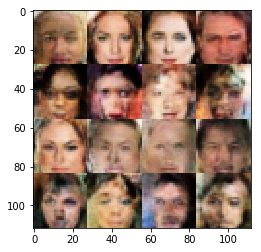

Epoch 1/1... Discriminator Loss: 0.7010... Generator Loss: 1.9615
Epoch 1/1... Discriminator Loss: 0.7566... Generator Loss: 1.8689
Epoch 1/1... Discriminator Loss: 0.7058... Generator Loss: 1.6761
Epoch 1/1... Discriminator Loss: 0.7852... Generator Loss: 1.4454
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 0.6474... Generator Loss: 2.1532
Epoch 1/1... Discriminator Loss: 0.6411... Generator Loss: 2.3207
Epoch 1/1... Discriminator Loss: 0.5343... Generator Loss: 3.0869
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 1.3264
Epoch 1/1... Discriminator Loss: 0.6392... Generator Loss: 3.1642
Epoch 1/1... Discriminator Loss: 0.7266... Generator Loss: 1.6494
Epoch 1/1... Discriminator Loss: 0.6722... Generator Loss: 1.8740
Epoch 1/1... Discriminator Loss: 0.6167... Generator Loss: 3.1963
Epoch 1/1... Discriminator Loss: 0.8033... Generator Loss: 1.6512
Epoch 1/1... Discriminator Loss: 0.6535... Generator Loss: 2.7378
Epoch 1/1.

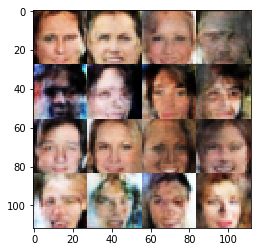

Epoch 1/1... Discriminator Loss: 0.5158... Generator Loss: 2.9157
Epoch 1/1... Discriminator Loss: 0.3479... Generator Loss: 6.0384
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 1.6644
Epoch 1/1... Discriminator Loss: 0.6773... Generator Loss: 2.5904
Epoch 1/1... Discriminator Loss: 0.5831... Generator Loss: 3.0625
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 1.3256
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 1.1371
Epoch 1/1... Discriminator Loss: 0.9136... Generator Loss: 2.3581
Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 0.8329... Generator Loss: 1.8394
Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 1.2601
Epoch 1/1... Discriminator Loss: 0.6663... Generator Loss: 3.1682
Epoch 1/1... Discriminator Loss: 0.6497... Generator Loss: 2.0229
Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 1.8250
Epoch 1/1.

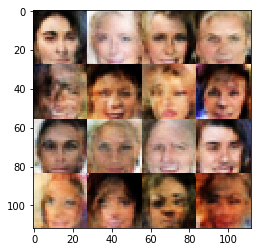

Epoch 1/1... Discriminator Loss: 0.6755... Generator Loss: 2.1260
Epoch 1/1... Discriminator Loss: 0.7844... Generator Loss: 1.4738
Epoch 1/1... Discriminator Loss: 0.6881... Generator Loss: 2.3417
Epoch 1/1... Discriminator Loss: 0.7056... Generator Loss: 1.8237
Epoch 1/1... Discriminator Loss: 0.5731... Generator Loss: 2.0413
Epoch 1/1... Discriminator Loss: 0.7089... Generator Loss: 2.6780
Epoch 1/1... Discriminator Loss: 0.5613... Generator Loss: 2.9074
Epoch 1/1... Discriminator Loss: 0.8027... Generator Loss: 1.5767
Epoch 1/1... Discriminator Loss: 0.6540... Generator Loss: 3.0971
Epoch 1/1... Discriminator Loss: 0.4943... Generator Loss: 3.3672
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 0.9894
Epoch 1/1... Discriminator Loss: 0.8939... Generator Loss: 2.7620
Epoch 1/1... Discriminator Loss: 0.7383... Generator Loss: 1.6966
Epoch 1/1... Discriminator Loss: 0.7866... Generator Loss: 1.5530
Epoch 1/1... Discriminator Loss: 0.7685... Generator Loss: 4.1399
Epoch 1/1.

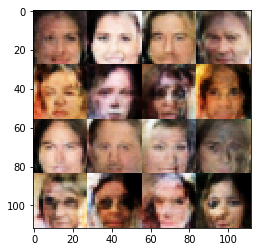

Epoch 1/1... Discriminator Loss: 0.5931... Generator Loss: 2.0252
Epoch 1/1... Discriminator Loss: 0.8271... Generator Loss: 1.3130
Epoch 1/1... Discriminator Loss: 0.6893... Generator Loss: 2.0403
Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 1.4252
Epoch 1/1... Discriminator Loss: 0.8480... Generator Loss: 1.1630
Epoch 1/1... Discriminator Loss: 0.5551... Generator Loss: 3.9748
Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 2.2194
Epoch 1/1... Discriminator Loss: 0.5999... Generator Loss: 2.5298
Epoch 1/1... Discriminator Loss: 0.7981... Generator Loss: 1.4102
Epoch 1/1... Discriminator Loss: 0.7038... Generator Loss: 2.6875
Epoch 1/1... Discriminator Loss: 0.7976... Generator Loss: 1.2801
Epoch 1/1... Discriminator Loss: 0.5905... Generator Loss: 2.1920
Epoch 1/1... Discriminator Loss: 0.5821... Generator Loss: 2.7024
Epoch 1/1... Discriminator Loss: 0.7292... Generator Loss: 1.8218
Epoch 1/1... Discriminator Loss: 0.6933... Generator Loss: 1.9110
Epoch 1/1.

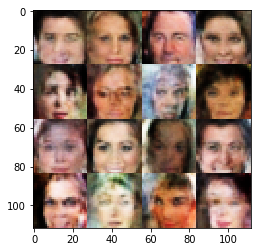

Epoch 1/1... Discriminator Loss: 0.5028... Generator Loss: 3.0796
Epoch 1/1... Discriminator Loss: 0.6545... Generator Loss: 1.8756
Epoch 1/1... Discriminator Loss: 0.5507... Generator Loss: 3.0234
Epoch 1/1... Discriminator Loss: 0.7001... Generator Loss: 1.7673
Epoch 1/1... Discriminator Loss: 0.6591... Generator Loss: 1.9228
Epoch 1/1... Discriminator Loss: 0.6071... Generator Loss: 2.5650
Epoch 1/1... Discriminator Loss: 0.7424... Generator Loss: 2.0557
Epoch 1/1... Discriminator Loss: 0.5174... Generator Loss: 2.5418
Epoch 1/1... Discriminator Loss: 0.6080... Generator Loss: 2.2265
Epoch 1/1... Discriminator Loss: 0.7215... Generator Loss: 1.5847
Epoch 1/1... Discriminator Loss: 0.6425... Generator Loss: 1.8725
Epoch 1/1... Discriminator Loss: 0.4807... Generator Loss: 2.9965
Epoch 1/1... Discriminator Loss: 0.4262... Generator Loss: 4.0040
Epoch 1/1... Discriminator Loss: 0.8342... Generator Loss: 1.2904
Epoch 1/1... Discriminator Loss: 0.7244... Generator Loss: 1.8381
Epoch 1/1.

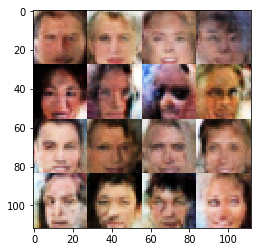

Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 3.1347
Epoch 1/1... Discriminator Loss: 0.8562... Generator Loss: 1.3032
Epoch 1/1... Discriminator Loss: 0.7755... Generator Loss: 1.6586
Epoch 1/1... Discriminator Loss: 0.6720... Generator Loss: 2.9664
Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 1.2336
Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 1.4957
Epoch 1/1... Discriminator Loss: 0.8379... Generator Loss: 1.2961
Epoch 1/1... Discriminator Loss: 0.7425... Generator Loss: 1.7091
Epoch 1/1... Discriminator Loss: 0.5630... Generator Loss: 3.5159
Epoch 1/1... Discriminator Loss: 0.8056... Generator Loss: 1.4608
Epoch 1/1... Discriminator Loss: 0.8534... Generator Loss: 2.0048
Epoch 1/1... Discriminator Loss: 0.8418... Generator Loss: 1.4029
Epoch 1/1... Discriminator Loss: 0.6760... Generator Loss: 2.6544
Epoch 1/1... Discriminator Loss: 0.8835... Generator Loss: 1.4409
Epoch 1/1... Discriminator Loss: 0.6379... Generator Loss: 2.5142
Epoch 1/1.

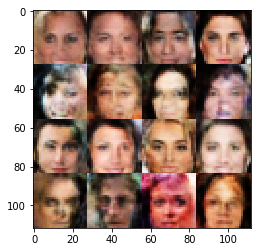

Epoch 1/1... Discriminator Loss: 0.6289... Generator Loss: 2.6149
Epoch 1/1... Discriminator Loss: 0.7641... Generator Loss: 1.4548
Epoch 1/1... Discriminator Loss: 0.7230... Generator Loss: 1.5733
Epoch 1/1... Discriminator Loss: 0.6135... Generator Loss: 2.6326
Epoch 1/1... Discriminator Loss: 0.5286... Generator Loss: 2.4518
Epoch 1/1... Discriminator Loss: 0.5571... Generator Loss: 3.4612
Epoch 1/1... Discriminator Loss: 0.6555... Generator Loss: 2.4138
Epoch 1/1... Discriminator Loss: 0.7069... Generator Loss: 1.9514
Epoch 1/1... Discriminator Loss: 0.7829... Generator Loss: 1.3686
Epoch 1/1... Discriminator Loss: 0.6646... Generator Loss: 2.2238
Epoch 1/1... Discriminator Loss: 0.7254... Generator Loss: 1.5707
Epoch 1/1... Discriminator Loss: 0.6249... Generator Loss: 2.1985
Epoch 1/1... Discriminator Loss: 0.4905... Generator Loss: 3.0648
Epoch 1/1... Discriminator Loss: 0.6329... Generator Loss: 2.1826
Epoch 1/1... Discriminator Loss: 0.6173... Generator Loss: 2.2379
Epoch 1/1.

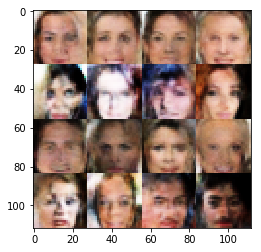

Epoch 1/1... Discriminator Loss: 0.8095... Generator Loss: 2.4968
Epoch 1/1... Discriminator Loss: 0.6891... Generator Loss: 1.8732
Epoch 1/1... Discriminator Loss: 0.6411... Generator Loss: 2.7062
Epoch 1/1... Discriminator Loss: 0.7508... Generator Loss: 1.6470
Epoch 1/1... Discriminator Loss: 0.7783... Generator Loss: 1.4854
Epoch 1/1... Discriminator Loss: 0.7459... Generator Loss: 1.6430
Epoch 1/1... Discriminator Loss: 0.6323... Generator Loss: 2.1434
Epoch 1/1... Discriminator Loss: 0.5048... Generator Loss: 2.8611
Epoch 1/1... Discriminator Loss: 0.6324... Generator Loss: 2.6977
Epoch 1/1... Discriminator Loss: 0.6620... Generator Loss: 2.1592
Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 3.0592
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 1.2085
Epoch 1/1... Discriminator Loss: 0.6975... Generator Loss: 3.9839
Epoch 1/1... Discriminator Loss: 0.6540... Generator Loss: 2.3204
Epoch 1/1... Discriminator Loss: 0.6909... Generator Loss: 2.6189
Epoch 1/1.

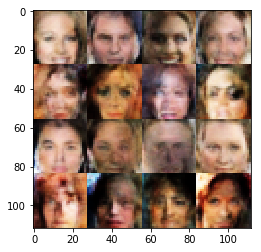

Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 1.4395
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 1.2376
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.9047
Epoch 1/1... Discriminator Loss: 0.7123... Generator Loss: 4.0947
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 2.1939
Epoch 1/1... Discriminator Loss: 0.8012... Generator Loss: 1.4365
Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 1.6590
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 2.6547
Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 1.8478
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 1.5997
Epoch 1/1... Discriminator Loss: 0.9956... Generator Loss: 1.1640
Epoch 1/1.

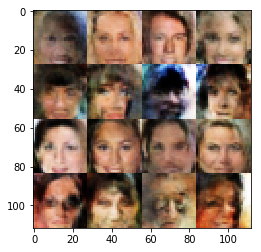

Epoch 1/1... Discriminator Loss: 0.5586... Generator Loss: 2.8619
Epoch 1/1... Discriminator Loss: 0.8856... Generator Loss: 1.2569
Epoch 1/1... Discriminator Loss: 0.8089... Generator Loss: 2.4294
Epoch 1/1... Discriminator Loss: 0.6245... Generator Loss: 1.8487
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 0.8148... Generator Loss: 1.8971
Epoch 1/1... Discriminator Loss: 0.7958... Generator Loss: 1.2770
Epoch 1/1... Discriminator Loss: 0.8100... Generator Loss: 1.3162
Epoch 1/1... Discriminator Loss: 0.6074... Generator Loss: 3.6302
Epoch 1/1... Discriminator Loss: 0.5859... Generator Loss: 2.7632
Epoch 1/1... Discriminator Loss: 0.7422... Generator Loss: 1.5672
Epoch 1/1... Discriminator Loss: 0.7530... Generator Loss: 2.1246
Epoch 1/1... Discriminator Loss: 0.7991... Generator Loss: 1.5598
Epoch 1/1... Discriminator Loss: 0.6250... Generator Loss: 2.2136
Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 1.7842
Epoch 1/1.

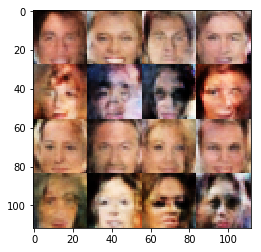

Epoch 1/1... Discriminator Loss: 0.7127... Generator Loss: 1.5871
Epoch 1/1... Discriminator Loss: 0.7465... Generator Loss: 2.5425
Epoch 1/1... Discriminator Loss: 0.5357... Generator Loss: 3.1503
Epoch 1/1... Discriminator Loss: 0.9049... Generator Loss: 2.0979
Epoch 1/1... Discriminator Loss: 0.6931... Generator Loss: 2.6851
Epoch 1/1... Discriminator Loss: 0.8154... Generator Loss: 1.3641
Epoch 1/1... Discriminator Loss: 0.8637... Generator Loss: 1.3160
Epoch 1/1... Discriminator Loss: 0.7703... Generator Loss: 1.9876
Epoch 1/1... Discriminator Loss: 0.4948... Generator Loss: 3.9102
Epoch 1/1... Discriminator Loss: 0.5622... Generator Loss: 2.7417
Epoch 1/1... Discriminator Loss: 0.6498... Generator Loss: 2.1358
Epoch 1/1... Discriminator Loss: 0.7049... Generator Loss: 2.2897
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 1.1974
Epoch 1/1... Discriminator Loss: 0.6946... Generator Loss: 2.1707
Epoch 1/1... Discriminator Loss: 0.5642... Generator Loss: 2.1052
Epoch 1/1.

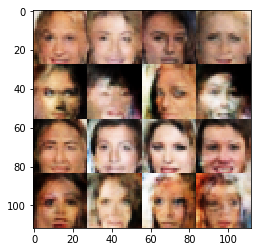

Epoch 1/1... Discriminator Loss: 0.7263... Generator Loss: 1.9879
Epoch 1/1... Discriminator Loss: 0.8828... Generator Loss: 1.0967
Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 1.6131
Epoch 1/1... Discriminator Loss: 0.7411... Generator Loss: 1.7342
Epoch 1/1... Discriminator Loss: 0.5185... Generator Loss: 3.0907
Epoch 1/1... Discriminator Loss: 0.8408... Generator Loss: 1.3500
Epoch 1/1... Discriminator Loss: 0.7322... Generator Loss: 2.1773
Epoch 1/1... Discriminator Loss: 0.7616... Generator Loss: 1.4099
Epoch 1/1... Discriminator Loss: 0.7982... Generator Loss: 1.3185
Epoch 1/1... Discriminator Loss: 0.7659... Generator Loss: 1.3815
Epoch 1/1... Discriminator Loss: 0.6838... Generator Loss: 1.8518
Epoch 1/1... Discriminator Loss: 0.6777... Generator Loss: 2.1793
Epoch 1/1... Discriminator Loss: 0.6914... Generator Loss: 2.0005
Epoch 1/1... Discriminator Loss: 0.5911... Generator Loss: 2.5611
Epoch 1/1... Discriminator Loss: 0.6023... Generator Loss: 2.3931
Epoch 1/1.

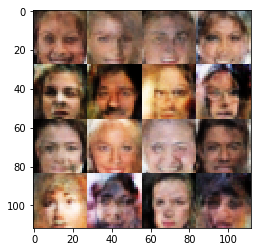

Epoch 1/1... Discriminator Loss: 0.8433... Generator Loss: 1.3768
Epoch 1/1... Discriminator Loss: 0.6137... Generator Loss: 2.4194
Epoch 1/1... Discriminator Loss: 0.6518... Generator Loss: 2.0980
Epoch 1/1... Discriminator Loss: 0.7090... Generator Loss: 1.7543
Epoch 1/1... Discriminator Loss: 0.7421... Generator Loss: 2.3985
Epoch 1/1... Discriminator Loss: 0.7214... Generator Loss: 1.9128
Epoch 1/1... Discriminator Loss: 0.7355... Generator Loss: 1.5728
Epoch 1/1... Discriminator Loss: 0.7460... Generator Loss: 1.6789
Epoch 1/1... Discriminator Loss: 0.7563... Generator Loss: 1.6001
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 0.7783... Generator Loss: 1.9731
Epoch 1/1... Discriminator Loss: 0.9231... Generator Loss: 1.0567
Epoch 1/1... Discriminator Loss: 0.6991... Generator Loss: 1.6611
Epoch 1/1... Discriminator Loss: 0.5021... Generator Loss: 3.2594
Epoch 1/1... Discriminator Loss: 0.8003... Generator Loss: 1.2551
Epoch 1/1.

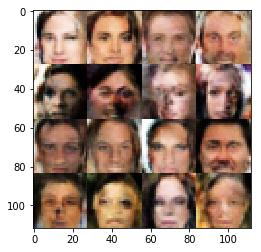

Epoch 1/1... Discriminator Loss: 0.7044... Generator Loss: 2.2159
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 1.2079
Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 1.0854
Epoch 1/1... Discriminator Loss: 0.6969... Generator Loss: 2.5897
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 0.7336... Generator Loss: 5.2222
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 2.6824
Epoch 1/1... Discriminator Loss: 0.7521... Generator Loss: 1.4084
Epoch 1/1... Discriminator Loss: 0.6307... Generator Loss: 2.1569
Epoch 1/1... Discriminator Loss: 0.7880... Generator Loss: 1.4341
Epoch 1/1... Discriminator Loss: 0.9022... Generator Loss: 1.1023
Epoch 1/1... Discriminator Loss: 0.7603... Generator Loss: 2.1365
Epoch 1/1... Discriminator Loss: 0.6250... Generator Loss: 1.9232
Epoch 1/1... Discriminator Loss: 0.7131... Generator Loss: 1.5561
Epoch 1/1.

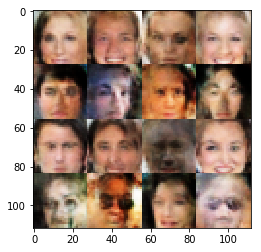

Epoch 1/1... Discriminator Loss: 0.8305... Generator Loss: 1.3392
Epoch 1/1... Discriminator Loss: 0.6823... Generator Loss: 2.5800
Epoch 1/1... Discriminator Loss: 0.8070... Generator Loss: 1.3787
Epoch 1/1... Discriminator Loss: 0.6395... Generator Loss: 1.7582
Epoch 1/1... Discriminator Loss: 0.9373... Generator Loss: 1.1187
Epoch 1/1... Discriminator Loss: 0.6775... Generator Loss: 2.1125
Epoch 1/1... Discriminator Loss: 0.7284... Generator Loss: 1.5512
Epoch 1/1... Discriminator Loss: 0.7860... Generator Loss: 1.6155
Epoch 1/1... Discriminator Loss: 0.6667... Generator Loss: 2.5157
Epoch 1/1... Discriminator Loss: 0.5934... Generator Loss: 2.6430
Epoch 1/1... Discriminator Loss: 0.6329... Generator Loss: 2.1380
Epoch 1/1... Discriminator Loss: 0.7941... Generator Loss: 1.7684
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 1.5956
Epoch 1/1... Discriminator Loss: 0.7307... Generator Loss: 1.8440
Epoch 1/1... Discriminator Loss: 0.6251... Generator Loss: 2.8178
Epoch 1/1.

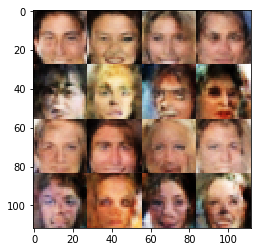

Epoch 1/1... Discriminator Loss: 0.8098... Generator Loss: 2.1449
Epoch 1/1... Discriminator Loss: 0.8268... Generator Loss: 1.6012
Epoch 1/1... Discriminator Loss: 0.7130... Generator Loss: 2.0976
Epoch 1/1... Discriminator Loss: 0.8019... Generator Loss: 1.9917
Epoch 1/1... Discriminator Loss: 1.0547... Generator Loss: 0.8974
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 1.1696
Epoch 1/1... Discriminator Loss: 0.5348... Generator Loss: 3.8298
Epoch 1/1... Discriminator Loss: 0.8063... Generator Loss: 1.4996
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 1.8612
Epoch 1/1... Discriminator Loss: 0.8295... Generator Loss: 1.4101
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 0.9503
Epoch 1/1... Discriminator Loss: 0.7535... Generator Loss: 1.6951
Epoch 1/1... Discriminator Loss: 0.6197... Generator Loss: 2.4522
Epoch 1/1... Discriminator Loss: 0.5520... Generator Loss: 3.5689
Epoch 1/1.

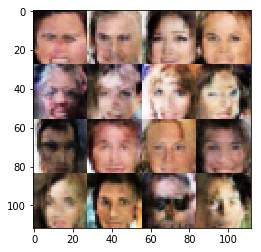

Epoch 1/1... Discriminator Loss: 0.7255... Generator Loss: 1.5947
Epoch 1/1... Discriminator Loss: 0.6699... Generator Loss: 2.5713
Epoch 1/1... Discriminator Loss: 0.4153... Generator Loss: 4.1231
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 1.4730
Epoch 1/1... Discriminator Loss: 0.7666... Generator Loss: 2.5791
Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 1.3622
Epoch 1/1... Discriminator Loss: 0.6734... Generator Loss: 1.9824
Epoch 1/1... Discriminator Loss: 0.7250... Generator Loss: 1.7035
Epoch 1/1... Discriminator Loss: 0.5899... Generator Loss: 3.5765
Epoch 1/1... Discriminator Loss: 0.4986... Generator Loss: 2.8967
Epoch 1/1... Discriminator Loss: 0.7364... Generator Loss: 1.5194
Epoch 1/1... Discriminator Loss: 0.6944... Generator Loss: 1.5638
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 1.0612
Epoch 1/1... Discriminator Loss: 0.4806... Generator Loss: 4.2925
Epoch 1/1... Discriminator Loss: 0.6707... Generator Loss: 1.8857
Epoch 1/1.

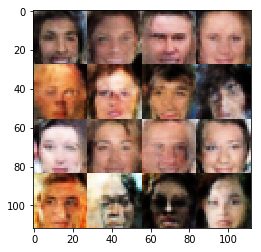

Epoch 1/1... Discriminator Loss: 0.7400... Generator Loss: 1.3789
Epoch 1/1... Discriminator Loss: 0.6378... Generator Loss: 2.4062
Epoch 1/1... Discriminator Loss: 1.5404... Generator Loss: 0.5256
Epoch 1/1... Discriminator Loss: 1.6673... Generator Loss: 2.4293
Epoch 1/1... Discriminator Loss: 1.8543... Generator Loss: 0.4031
Epoch 1/1... Discriminator Loss: 3.0492... Generator Loss: 3.8563
Epoch 1/1... Discriminator Loss: 6.3518... Generator Loss: 0.0532
Epoch 1/1... Discriminator Loss: 3.6464... Generator Loss: 4.5865
Epoch 1/1... Discriminator Loss: 3.5887... Generator Loss: 0.1999
Epoch 1/1... Discriminator Loss: 3.0961... Generator Loss: 4.2907
Epoch 1/1... Discriminator Loss: 2.1774... Generator Loss: 0.4624
Epoch 1/1... Discriminator Loss: 2.0420... Generator Loss: 2.4285
Epoch 1/1... Discriminator Loss: 3.8855... Generator Loss: 2.1962
Epoch 1/1... Discriminator Loss: 2.3124... Generator Loss: 2.5893
Epoch 1/1... Discriminator Loss: 3.1295... Generator Loss: 1.3757
Epoch 1/1.

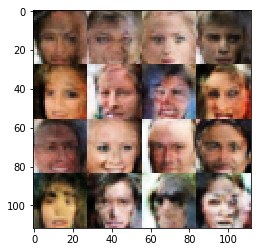

Epoch 1/1... Discriminator Loss: 0.8054... Generator Loss: 1.5227
Epoch 1/1... Discriminator Loss: 0.6877... Generator Loss: 2.3422
Epoch 1/1... Discriminator Loss: 0.5844... Generator Loss: 2.8854
Epoch 1/1... Discriminator Loss: 0.7400... Generator Loss: 1.9260
Epoch 1/1... Discriminator Loss: 0.8135... Generator Loss: 1.8529
Epoch 1/1... Discriminator Loss: 0.8059... Generator Loss: 1.4598
Epoch 1/1... Discriminator Loss: 0.8374... Generator Loss: 1.3398
Epoch 1/1... Discriminator Loss: 0.5949... Generator Loss: 2.3745
Epoch 1/1... Discriminator Loss: 0.5705... Generator Loss: 3.5455
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 2.1687
Epoch 1/1... Discriminator Loss: 0.8631... Generator Loss: 1.1512
Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 1.2541
Epoch 1/1... Discriminator Loss: 0.6737... Generator Loss: 2.1460
Epoch 1/1... Discriminator Loss: 0.7586... Generator Loss: 1.8441
Epoch 1/1.

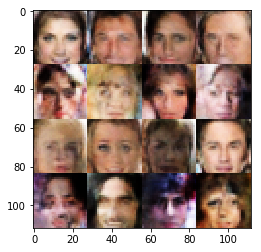

Epoch 1/1... Discriminator Loss: 0.5637... Generator Loss: 2.4909
Epoch 1/1... Discriminator Loss: 0.7944... Generator Loss: 1.3913
Epoch 1/1... Discriminator Loss: 0.9104... Generator Loss: 1.1379
Epoch 1/1... Discriminator Loss: 0.7993... Generator Loss: 1.6378
Epoch 1/1... Discriminator Loss: 0.9122... Generator Loss: 1.1063
Epoch 1/1... Discriminator Loss: 0.8334... Generator Loss: 1.3713
Epoch 1/1... Discriminator Loss: 0.6389... Generator Loss: 1.9797
Epoch 1/1... Discriminator Loss: 0.5989... Generator Loss: 2.2963
Epoch 1/1... Discriminator Loss: 0.7008... Generator Loss: 1.8095
Epoch 1/1... Discriminator Loss: 0.6328... Generator Loss: 2.1046
Epoch 1/1... Discriminator Loss: 0.6230... Generator Loss: 2.4890
Epoch 1/1... Discriminator Loss: 0.8556... Generator Loss: 1.3387
Epoch 1/1... Discriminator Loss: 0.5984... Generator Loss: 2.4176
Epoch 1/1... Discriminator Loss: 0.8044... Generator Loss: 1.4156
Epoch 1/1... Discriminator Loss: 0.5624... Generator Loss: 3.1677
Epoch 1/1.

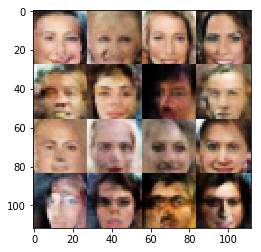

Epoch 1/1... Discriminator Loss: 0.7905... Generator Loss: 1.5172
Epoch 1/1... Discriminator Loss: 0.7536... Generator Loss: 1.5497
Epoch 1/1... Discriminator Loss: 0.9248... Generator Loss: 1.0608
Epoch 1/1... Discriminator Loss: 0.7592... Generator Loss: 1.4563
Epoch 1/1... Discriminator Loss: 0.5429... Generator Loss: 3.4165
Epoch 1/1... Discriminator Loss: 0.7309... Generator Loss: 1.4795
Epoch 1/1... Discriminator Loss: 0.7500... Generator Loss: 1.5209
Epoch 1/1... Discriminator Loss: 0.7597... Generator Loss: 1.4801
Epoch 1/1... Discriminator Loss: 0.6328... Generator Loss: 1.7887
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 1.3296
Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 2.3291
Epoch 1/1... Discriminator Loss: 0.5068... Generator Loss: 3.0693
Epoch 1/1... Discriminator Loss: 0.6053... Generator Loss: 2.5198
Epoch 1/1... Discriminator Loss: 0.4924... Generator Loss: 2.7791
Epoch 1/1... Discriminator Loss: 0.8618... Generator Loss: 1.2139
Epoch 1/1.

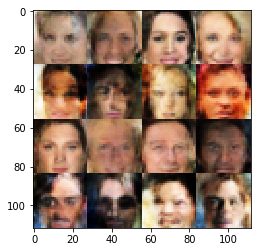

Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 1.9788
Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 0.7310... Generator Loss: 2.6821
Epoch 1/1... Discriminator Loss: 0.5210... Generator Loss: 3.0605
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 0.9113... Generator Loss: 2.0724
Epoch 1/1... Discriminator Loss: 0.7397... Generator Loss: 1.9475
Epoch 1/1... Discriminator Loss: 0.7049... Generator Loss: 2.2981
Epoch 1/1... Discriminator Loss: 0.7423... Generator Loss: 1.9911
Epoch 1/1... Discriminator Loss: 0.9162... Generator Loss: 1.2984
Epoch 1/1... Discriminator Loss: 0.7286... Generator Loss: 1.6209
Epoch 1/1... Discriminator Loss: 0.7069... Generator Loss: 1.7411
Epoch 1/1... Discriminator Loss: 0.6613... Generator Loss: 1.7134
Epoch 1/1... Discriminator Loss: 0.6264... Generator Loss: 1.9351
Epoch 1/1.

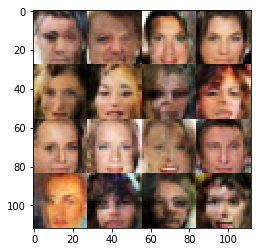

Epoch 1/1... Discriminator Loss: 0.6904... Generator Loss: 2.1513
Epoch 1/1... Discriminator Loss: 0.5913... Generator Loss: 3.6005
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 1.5094
Epoch 1/1... Discriminator Loss: 0.9497... Generator Loss: 1.2539
Epoch 1/1... Discriminator Loss: 0.9359... Generator Loss: 1.0840
Epoch 1/1... Discriminator Loss: 0.6250... Generator Loss: 3.3044
Epoch 1/1... Discriminator Loss: 0.5099... Generator Loss: 2.9685
Epoch 1/1... Discriminator Loss: 0.8157... Generator Loss: 1.3086
Epoch 1/1... Discriminator Loss: 0.6974... Generator Loss: 1.8399
Epoch 1/1... Discriminator Loss: 0.6159... Generator Loss: 2.0302
Epoch 1/1... Discriminator Loss: 0.8051... Generator Loss: 1.7328
Epoch 1/1... Discriminator Loss: 0.6133... Generator Loss: 2.3295
Epoch 1/1... Discriminator Loss: 0.7270... Generator Loss: 1.6710
Epoch 1/1... Discriminator Loss: 0.6162... Generator Loss: 2.0914
Epoch 1/1... Discriminator Loss: 0.7221... Generator Loss: 1.4851
Epoch 1/1.

In [13]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.